### Training Forecasting Time Series Data and Hybrid Recommendation Model with Azure AutoML and MovieLens Dataset
In this notebook we demonstrate how to build a Recommendation Model.The approach will use the Microsoft Azure [AutoML](https://azure.microsoft.com/en-us/solutions/automated-machine-learning) and [Mlflow](http://mlflow.org)

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; Setup <code>Access to Microsoft Azure Subscription</code>. <b>In addition, download the Forecasting Data - eastern_assets_oil_trend_2025 in this repo</b>
    
    1) First, we will perform a simple Forecasting with Time Series using the Eastern Asset Oil Trend
    2) Then, we build an Hybrid Recommendation Model using the MovieLens Dataset 
    3) <code>Python</code> will be used to build perform the second tasks and deploy it with Mlflow.</p>


<br>
<p> ⬇ &nbsp; <b>Training</b> 1) Step <em>can take up to a few hours</em> depending on your setting 2) Run <em>Consider the </em> training cost and serving cost <em> before any of these tasks</em>.</p>

<p> 📒 &nbsp; For Production - You can host the model on CPU/GPU Serverless Compute <em>or publicly on hugging face</em>.</p>

</div>

#### Submit your Training Job

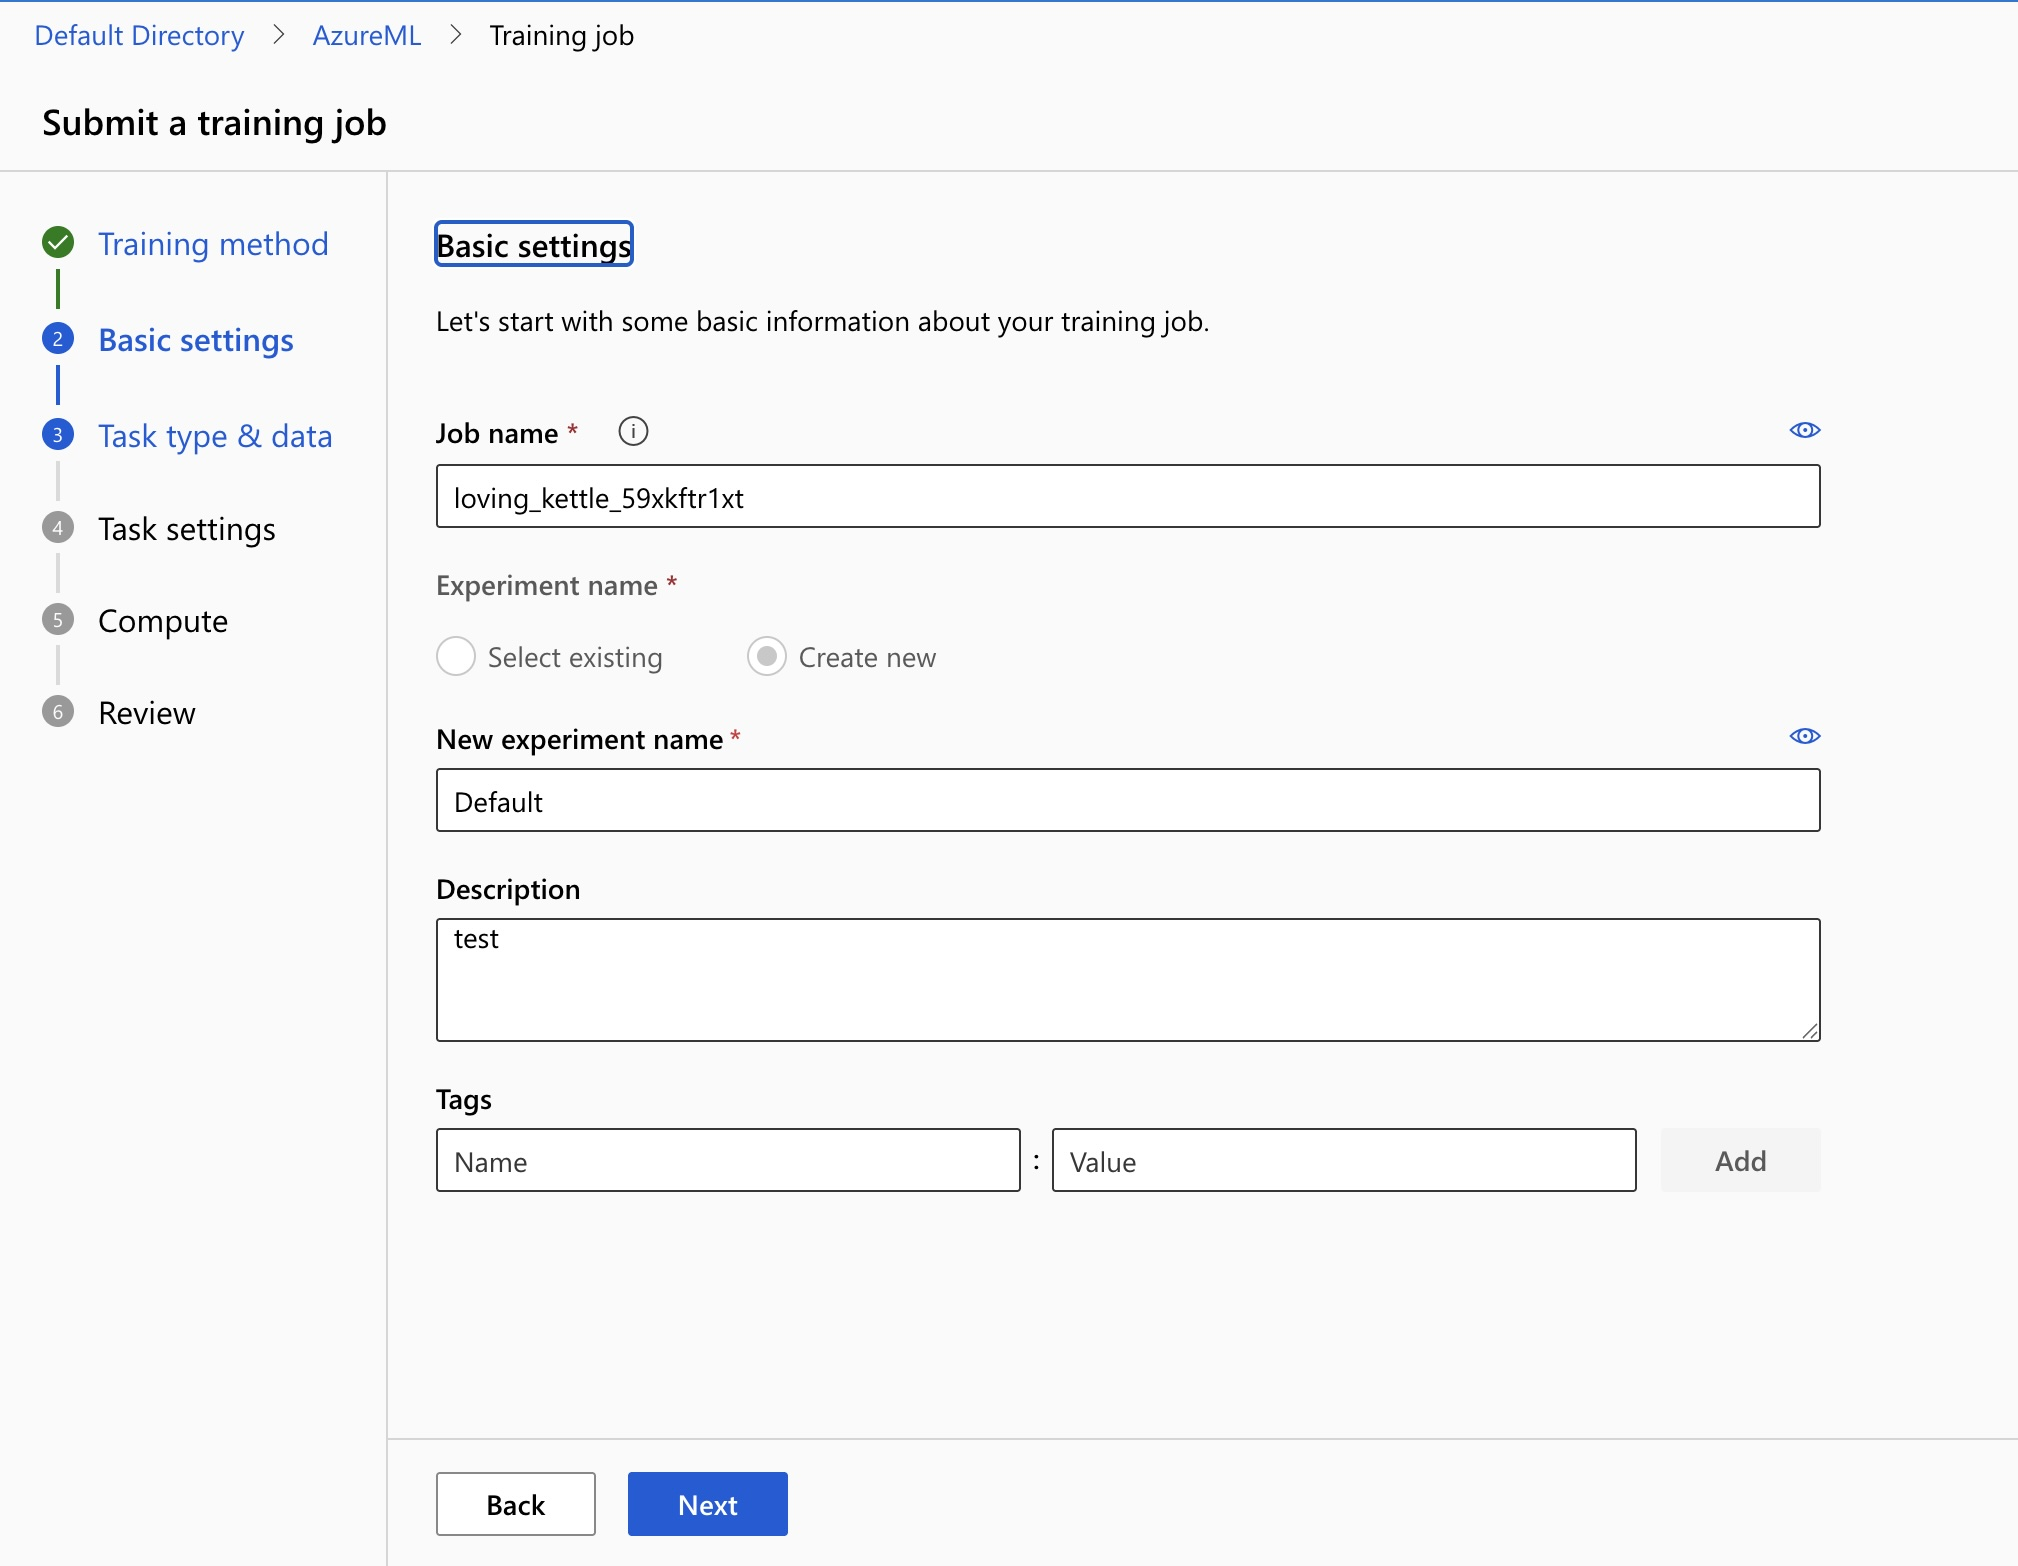

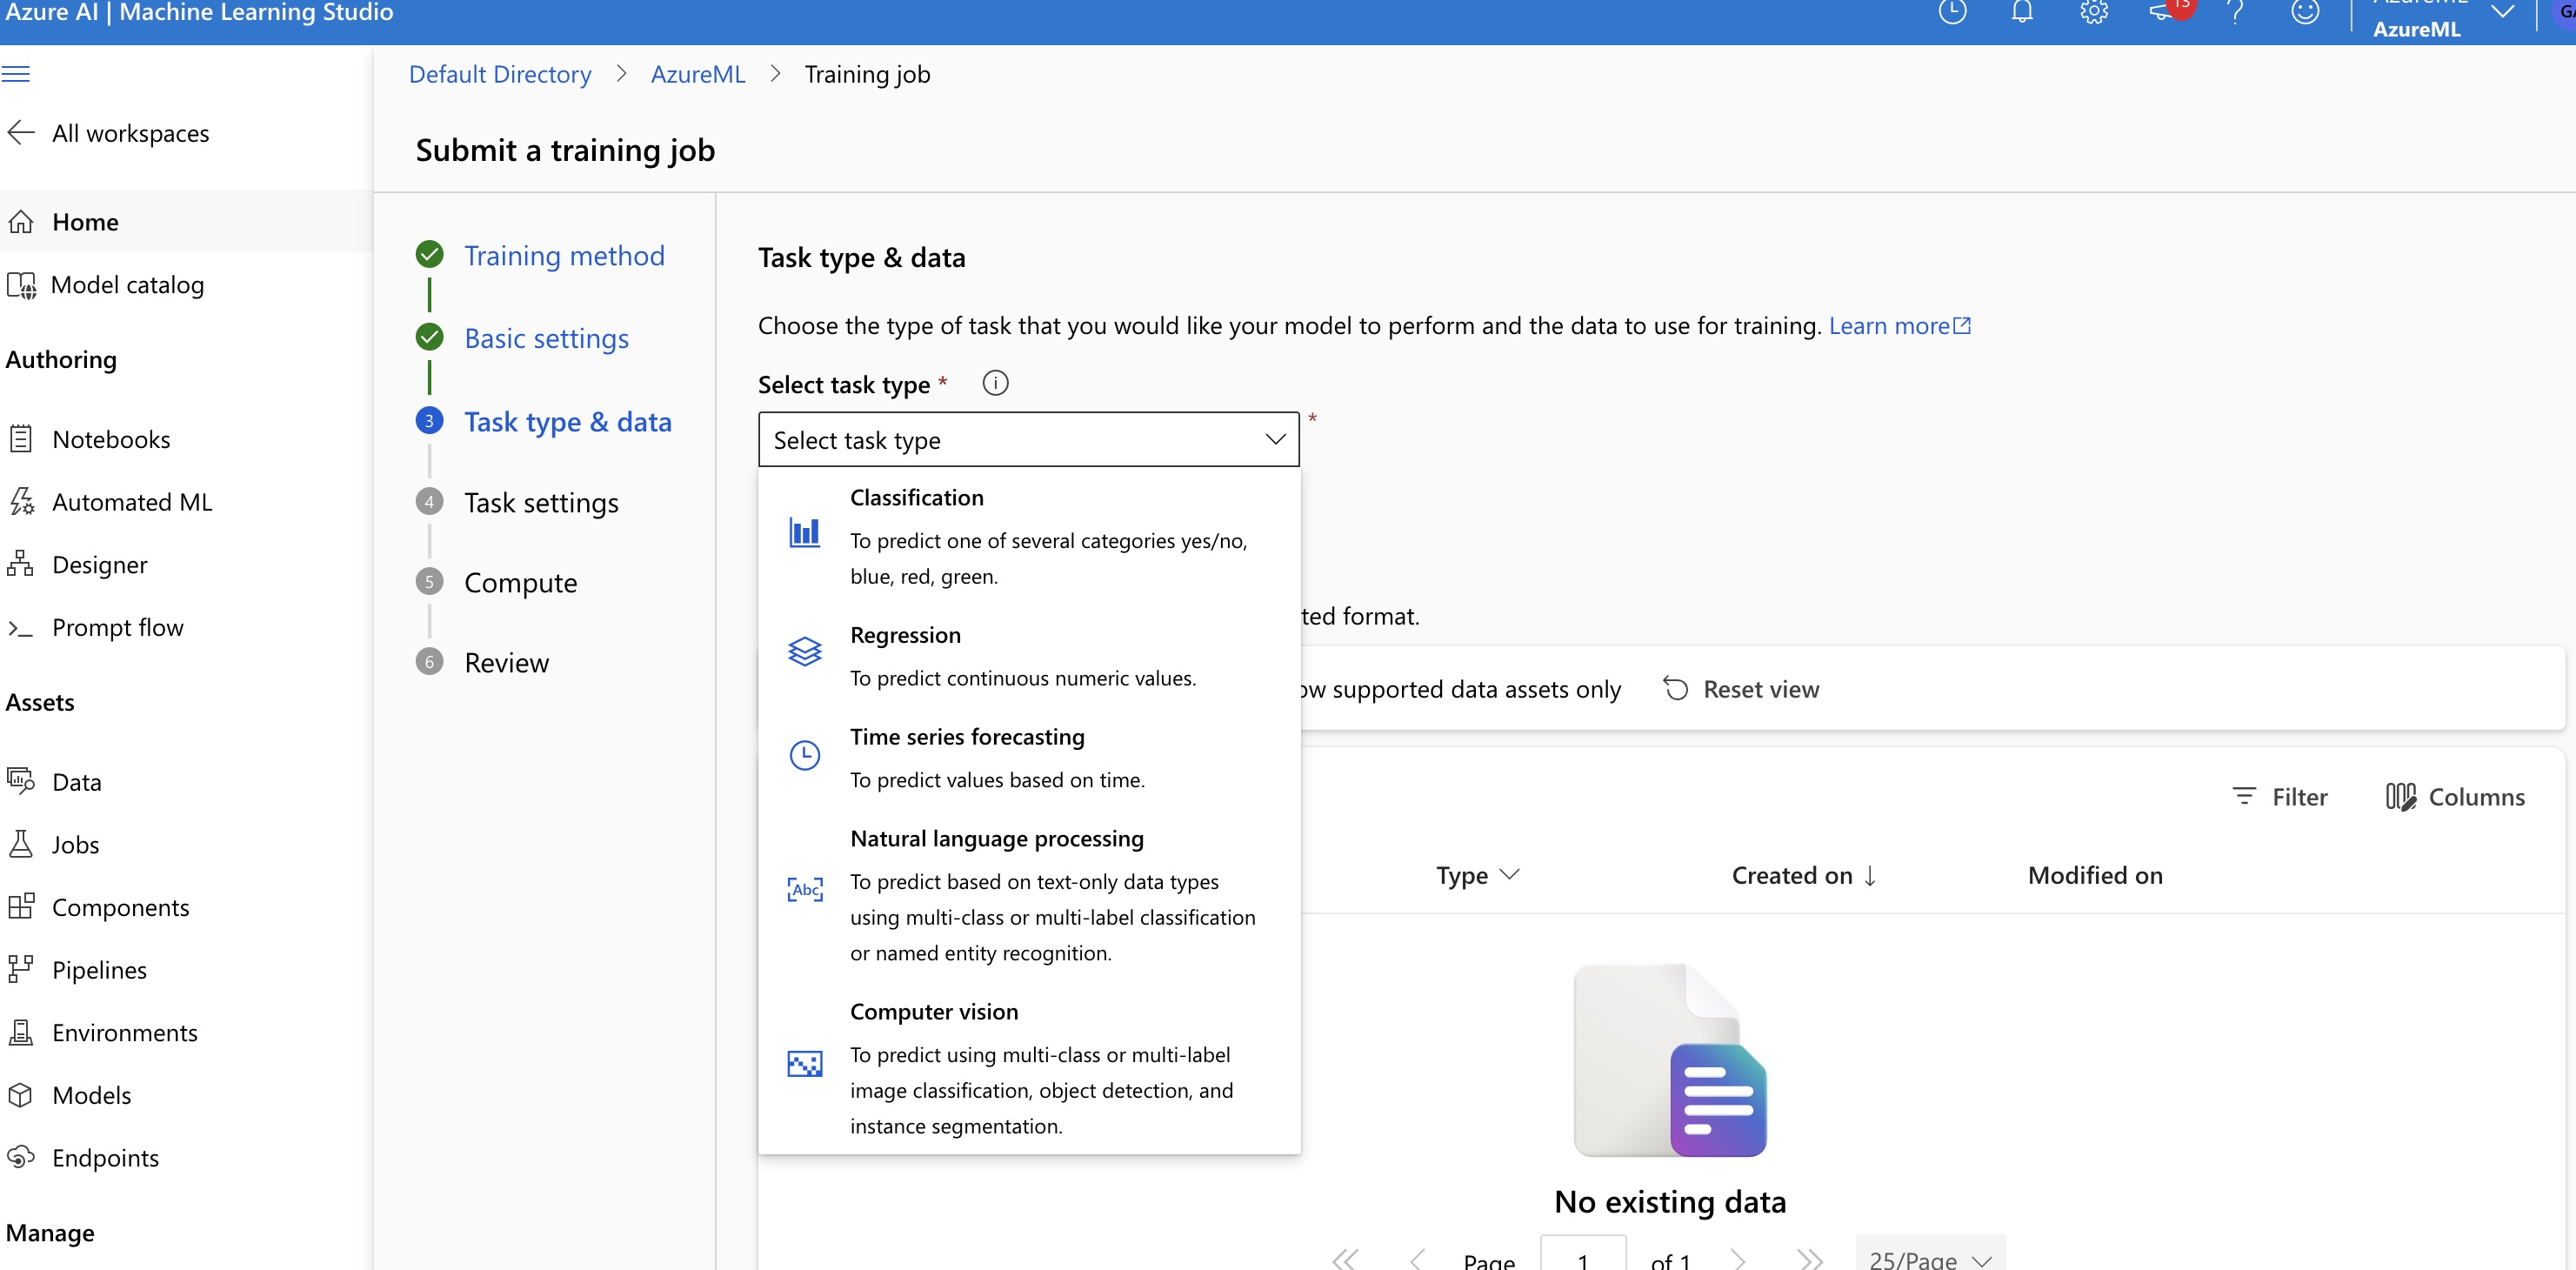

#### Prepare your Dataset

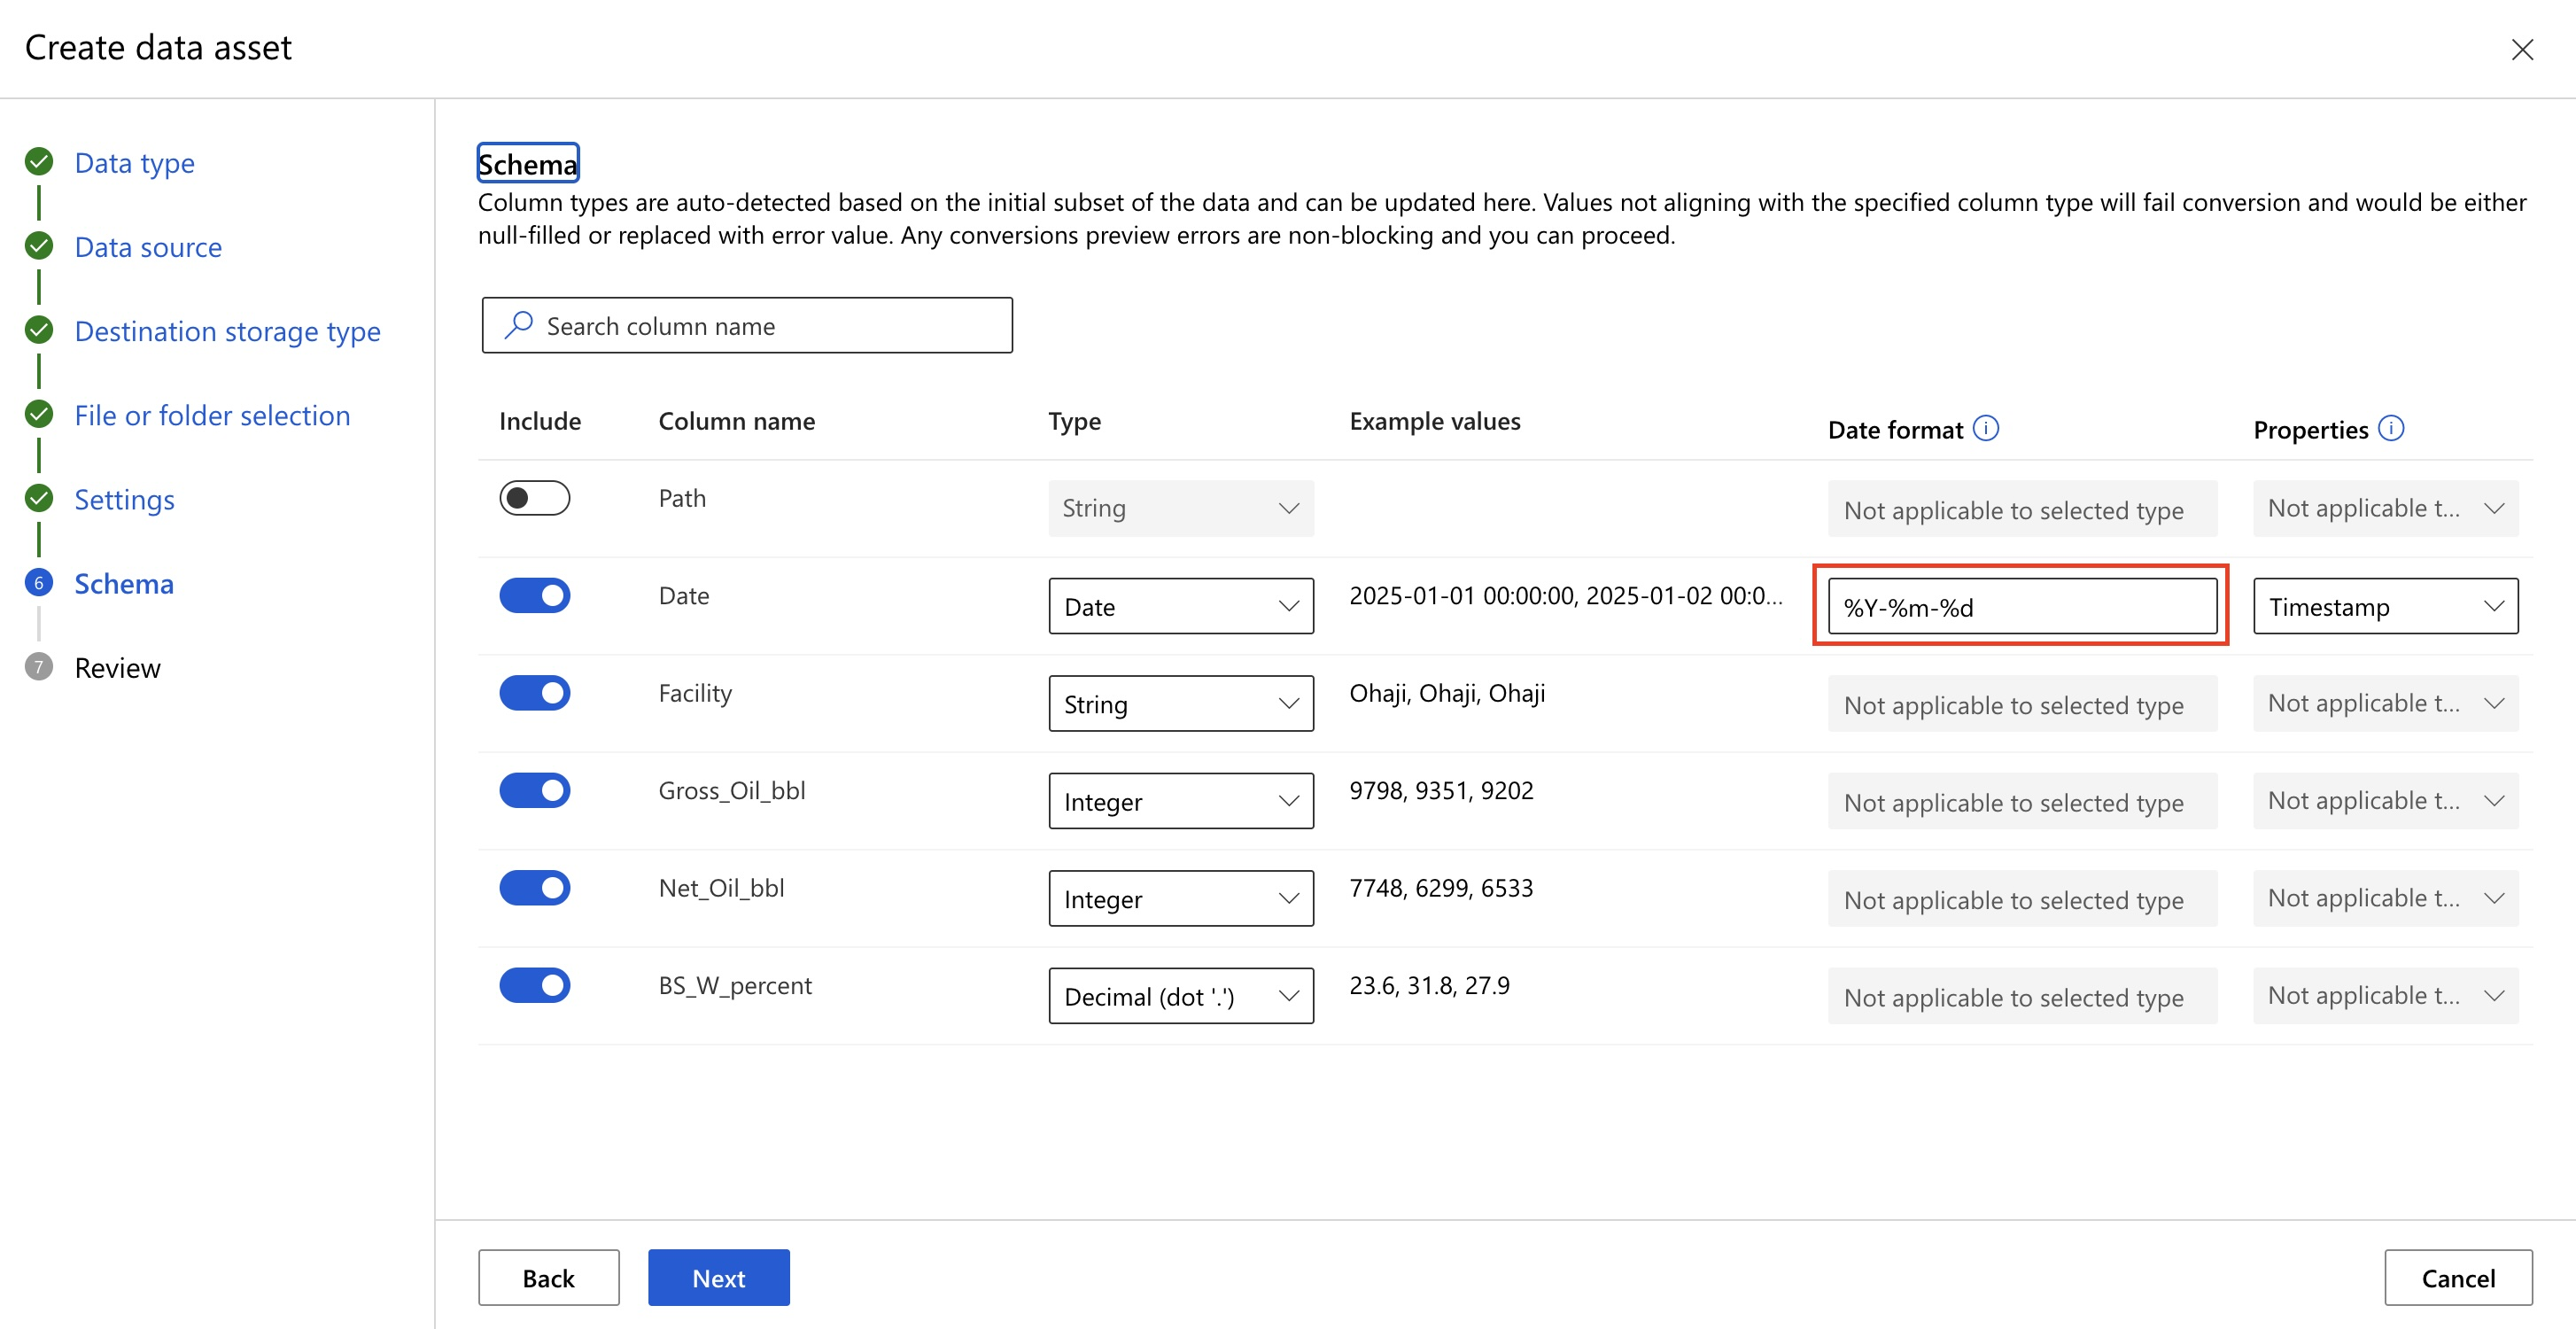

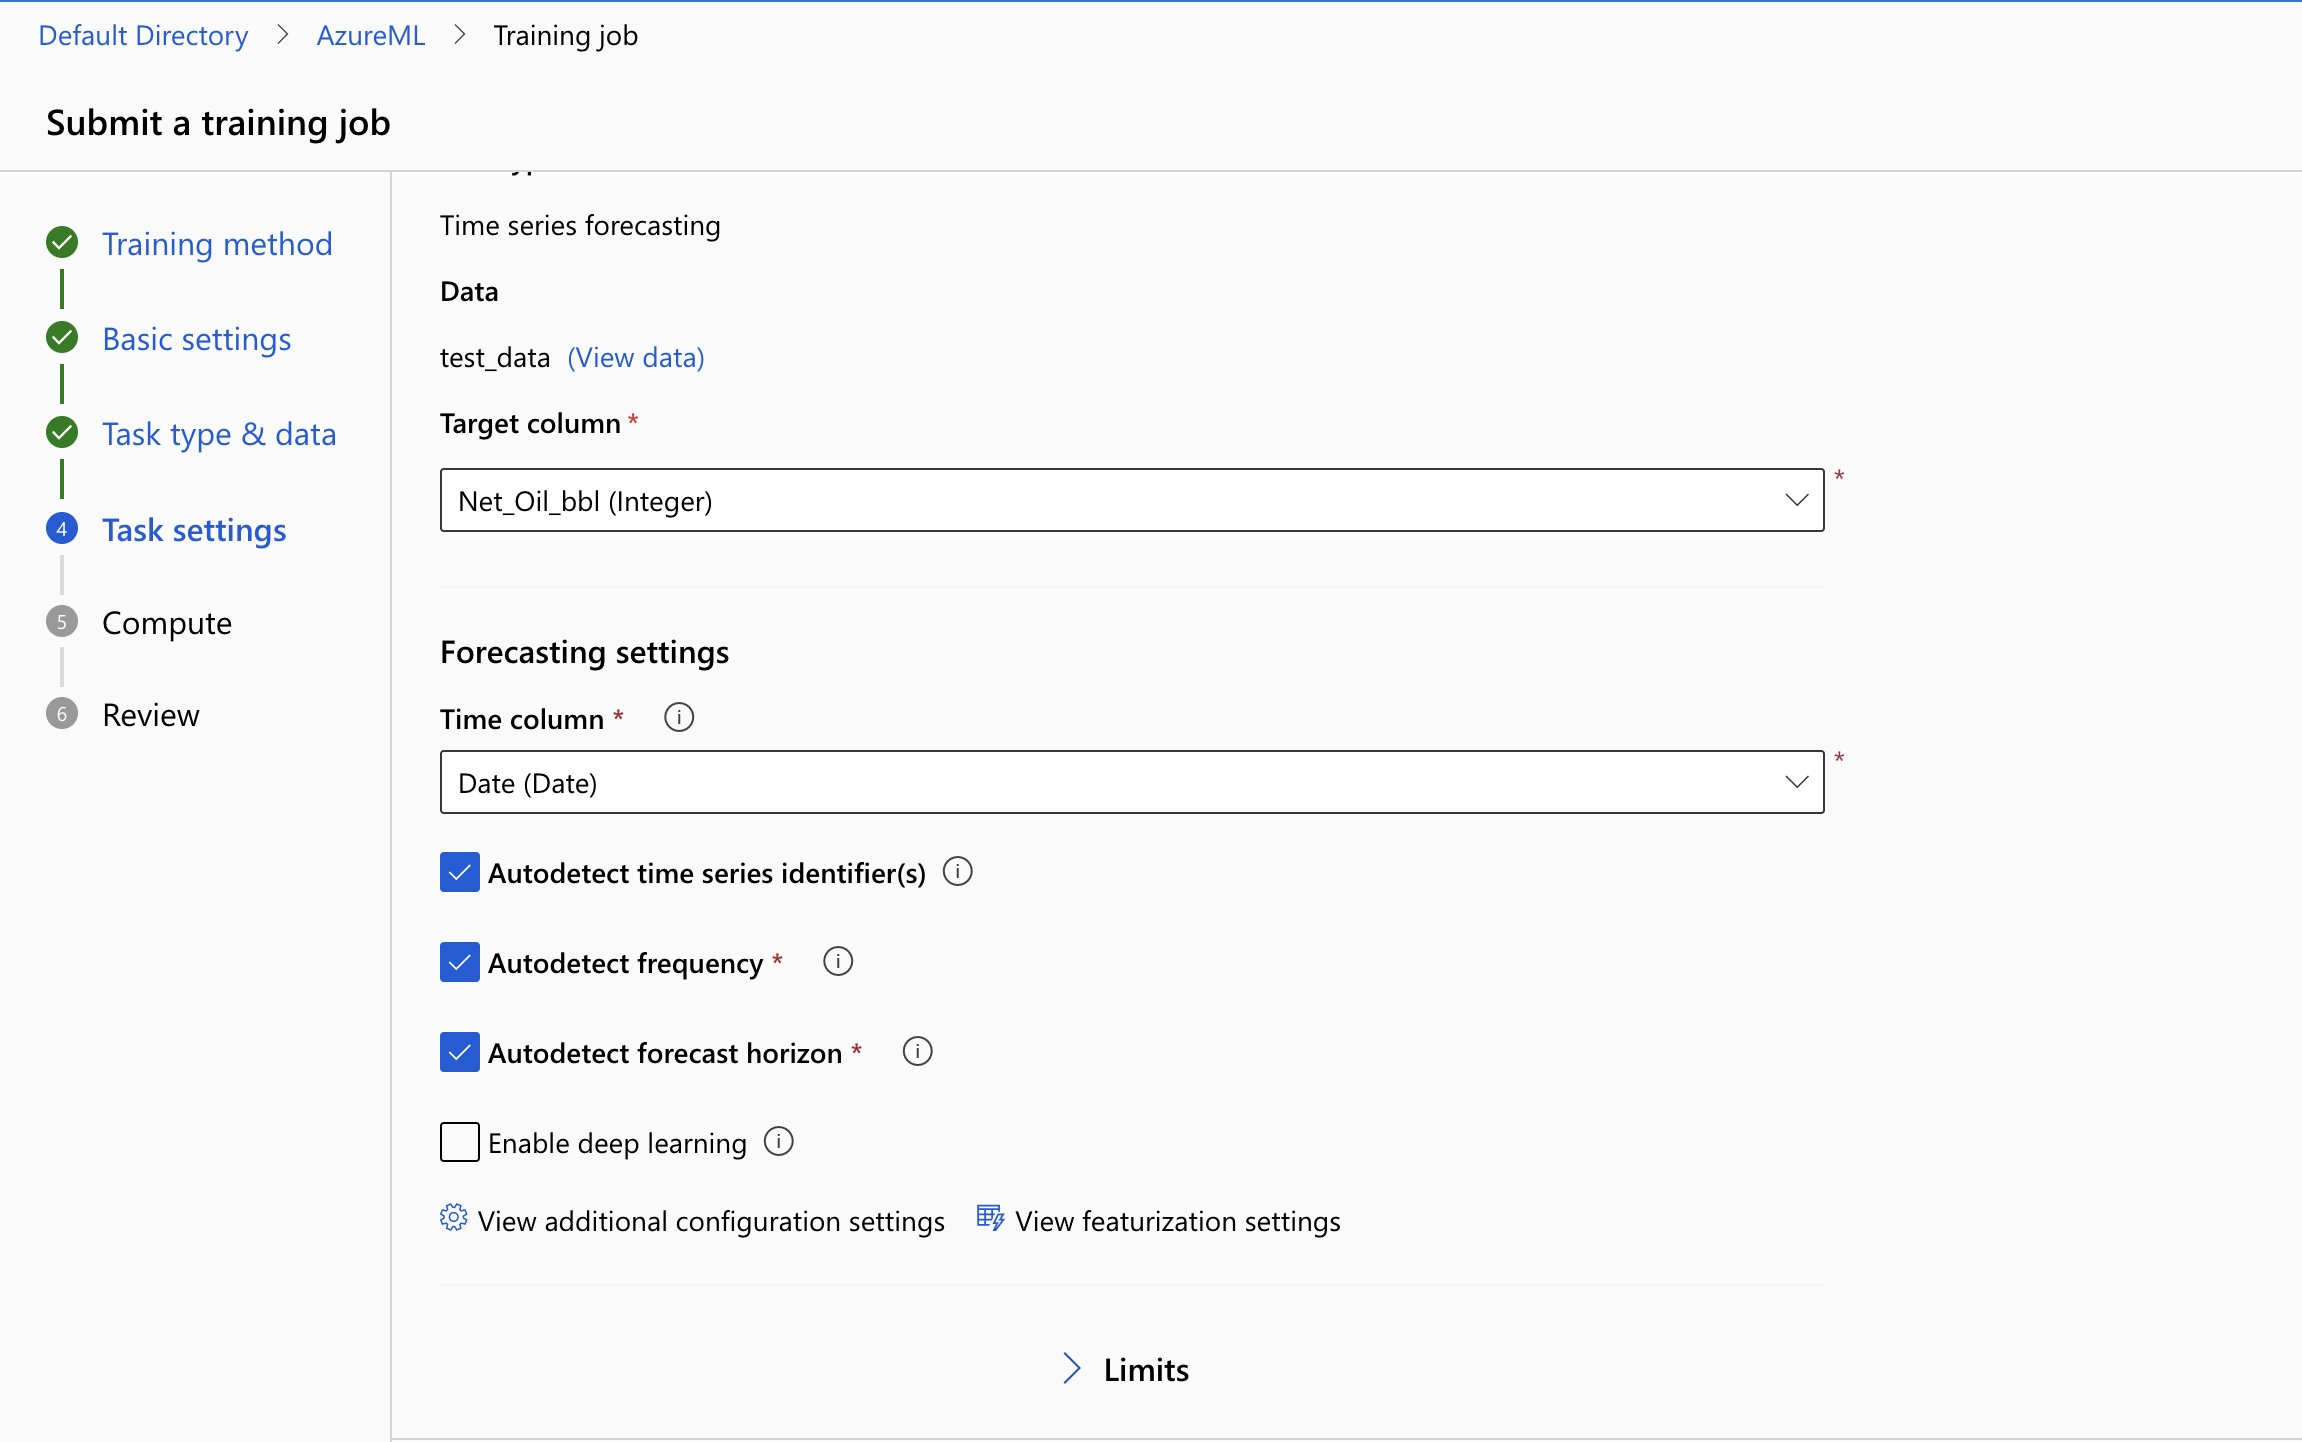

#### Additional Settings - Data Split, Validation Steps, Compute Shape

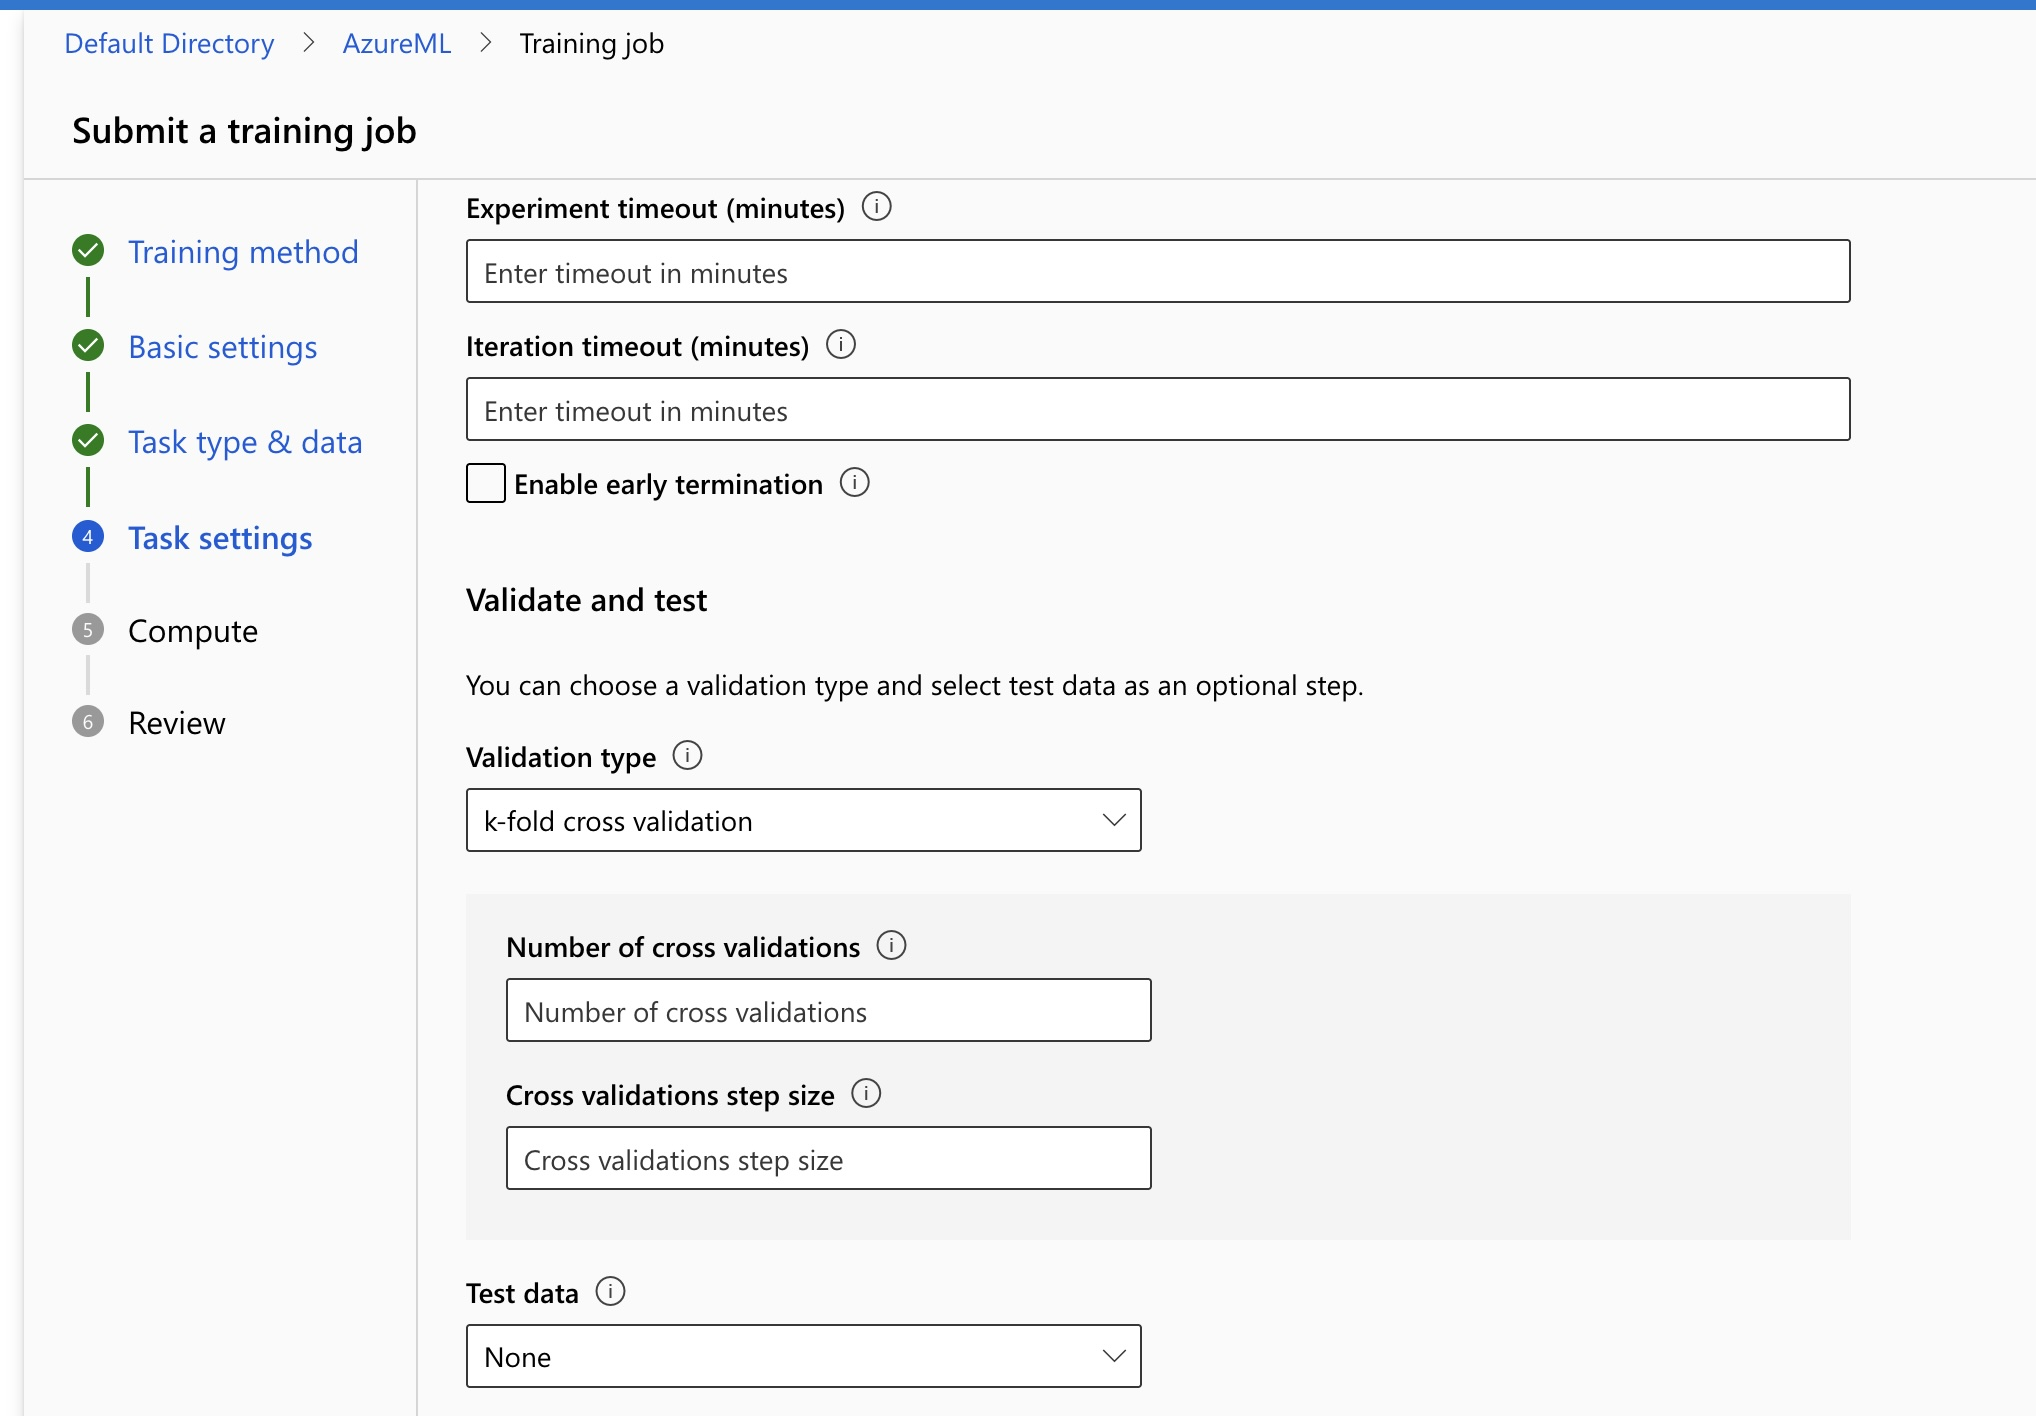

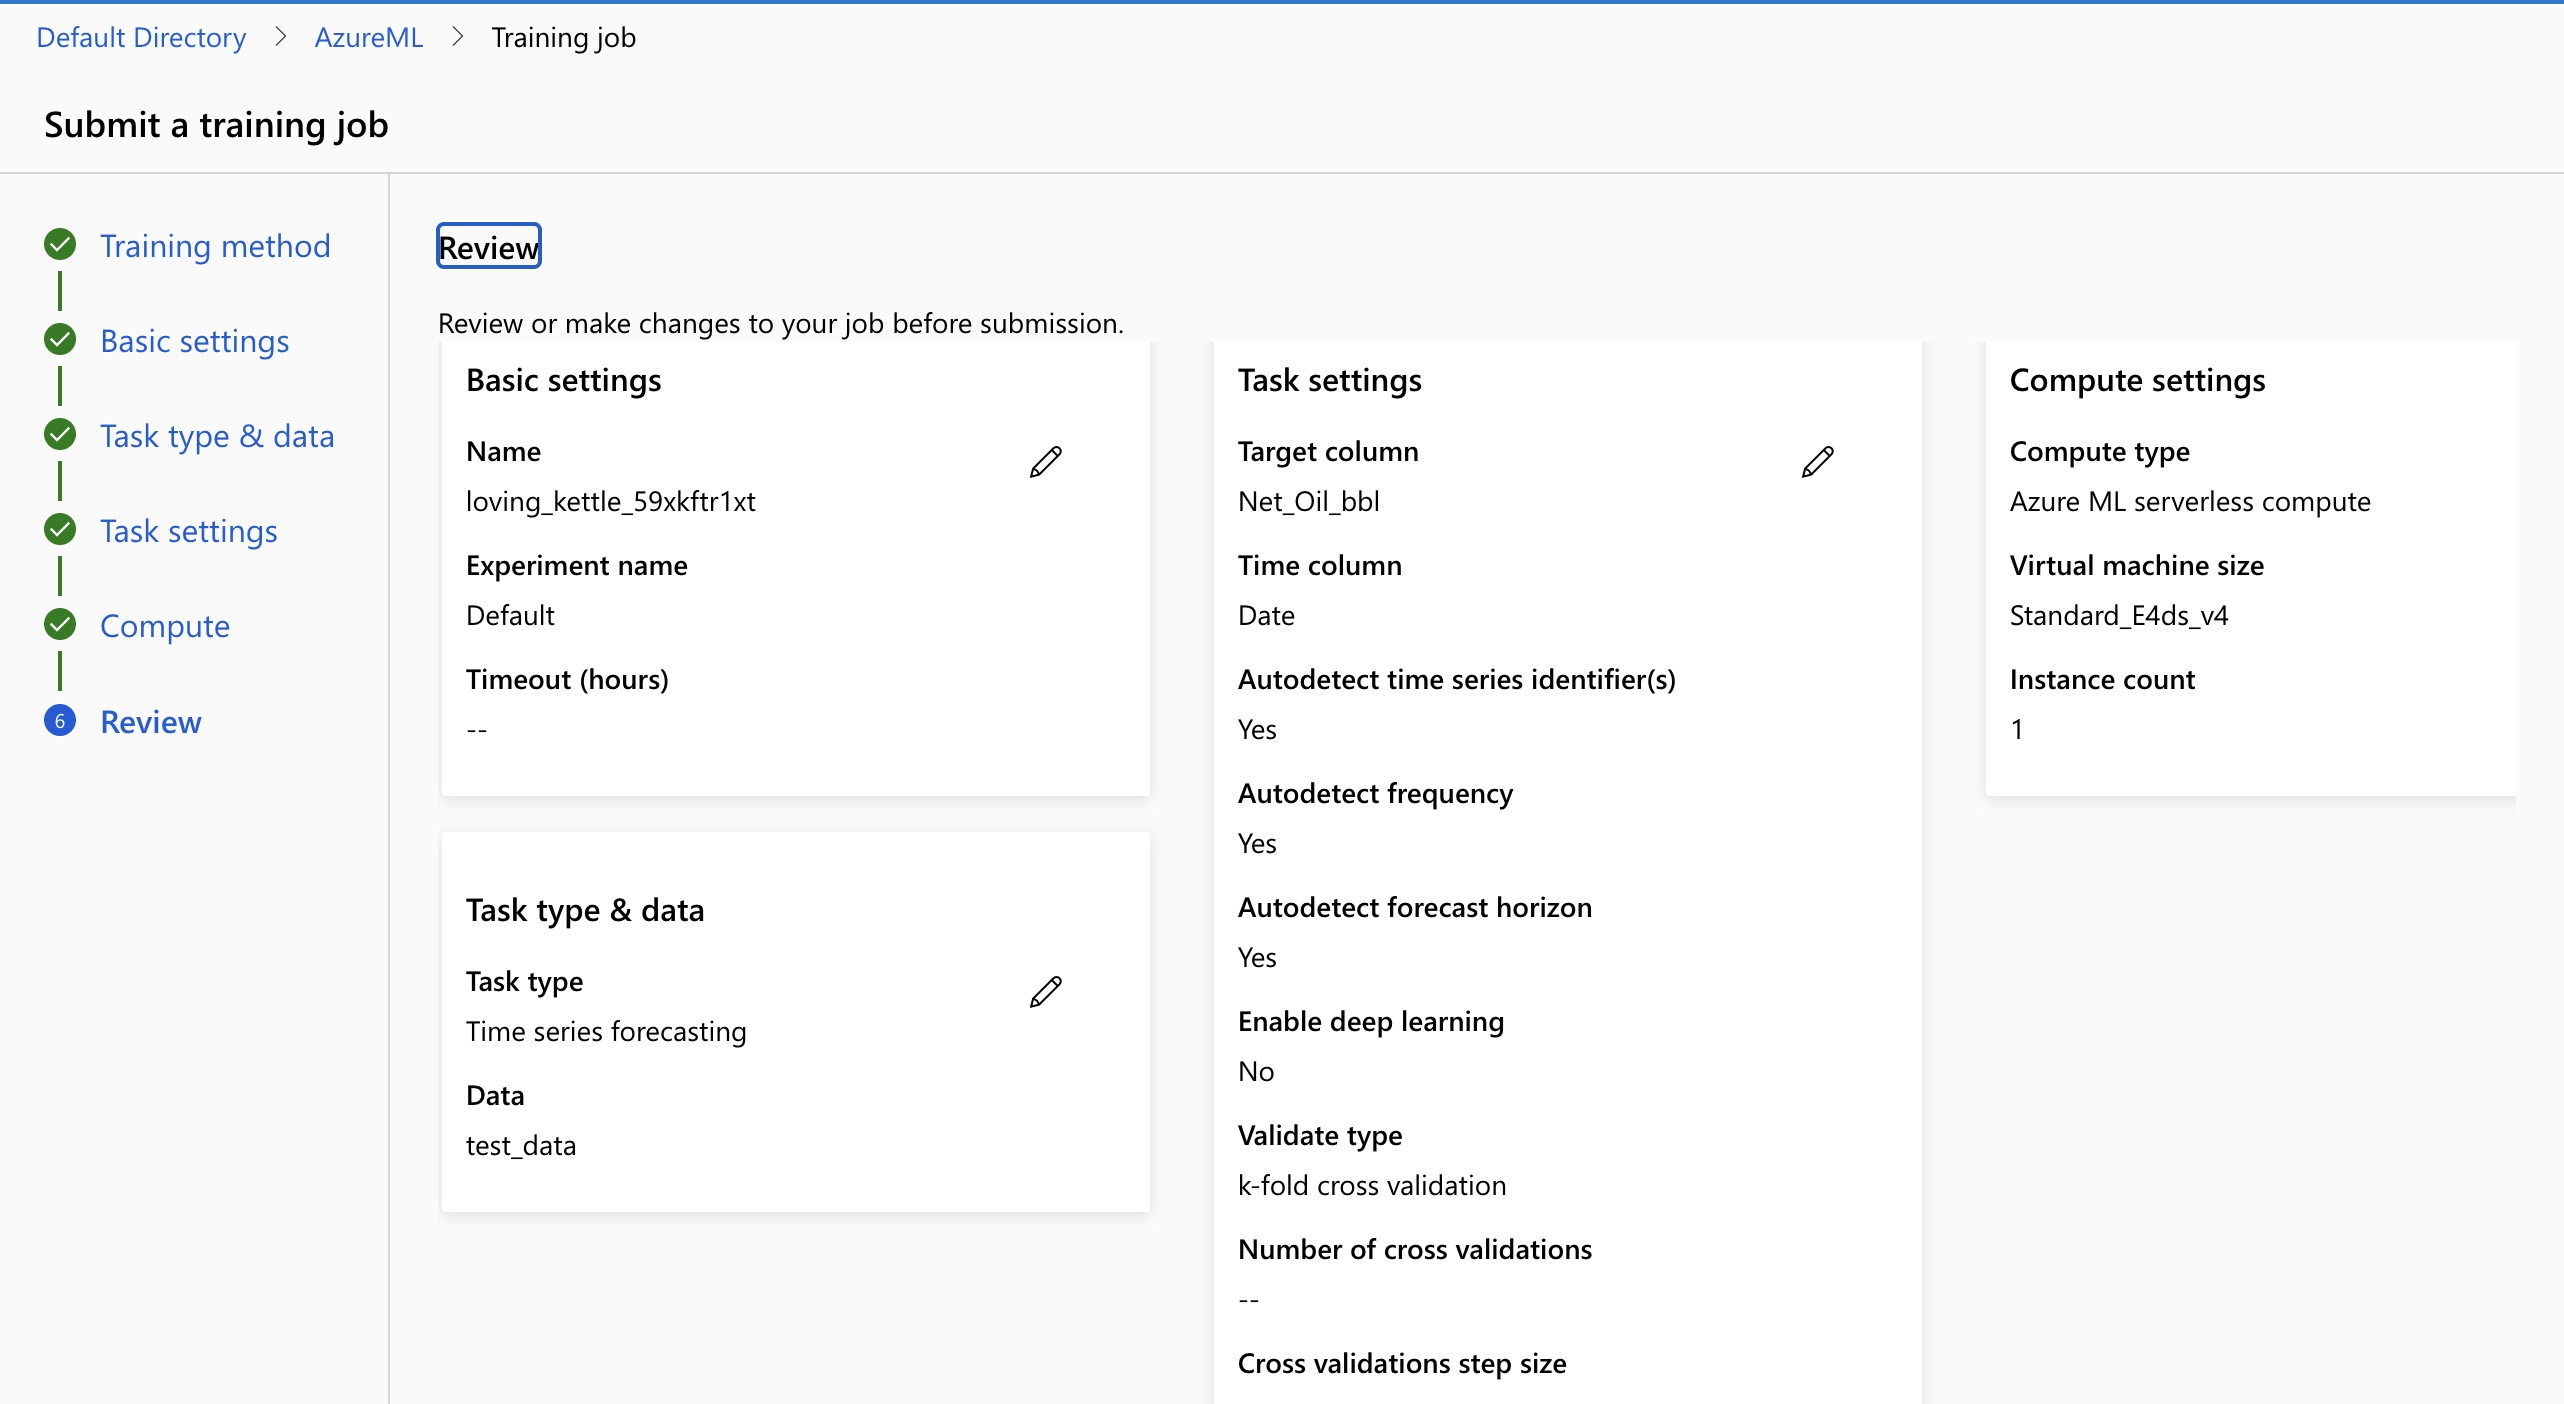

#### Review your Metrics

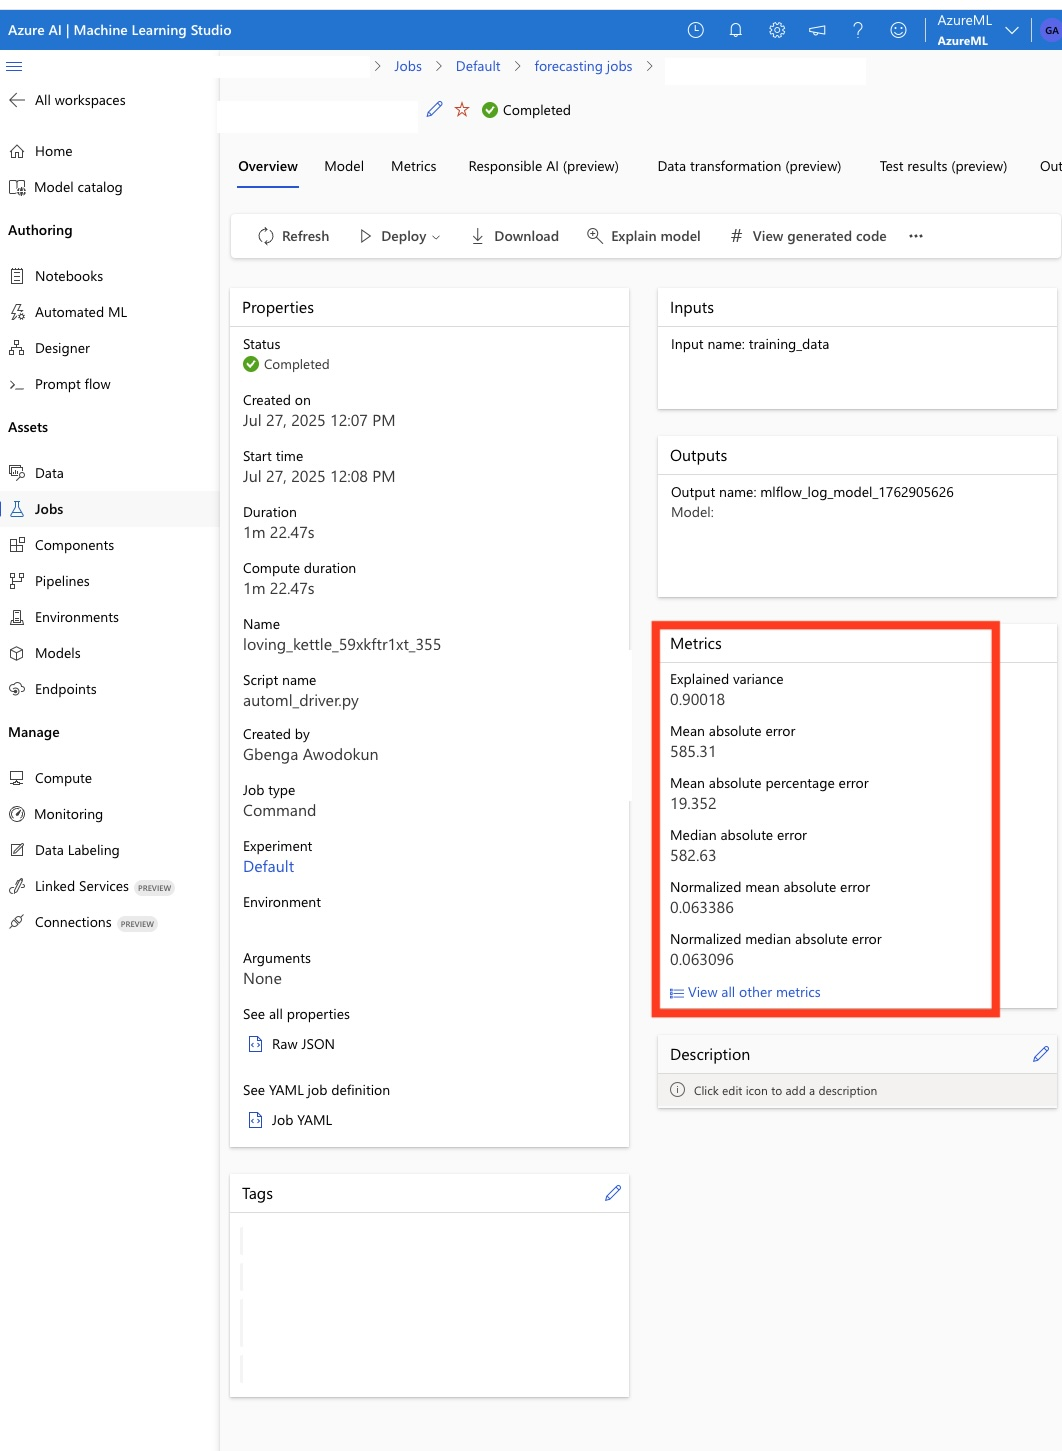

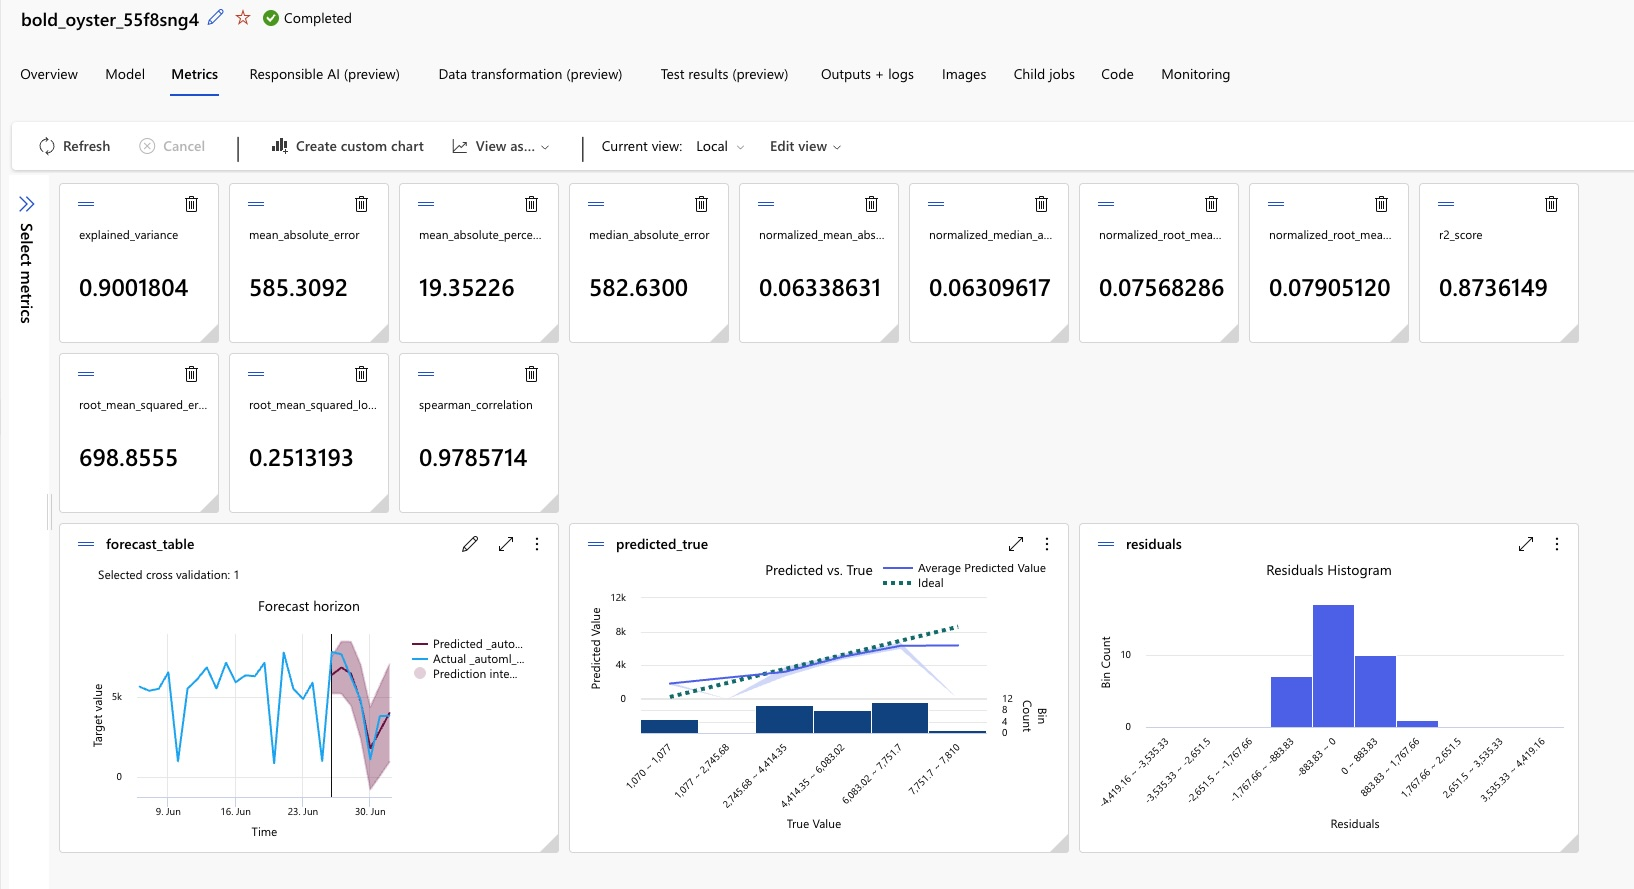

#### Productionalize the Model
##### Select what model run (experiment) you want to use
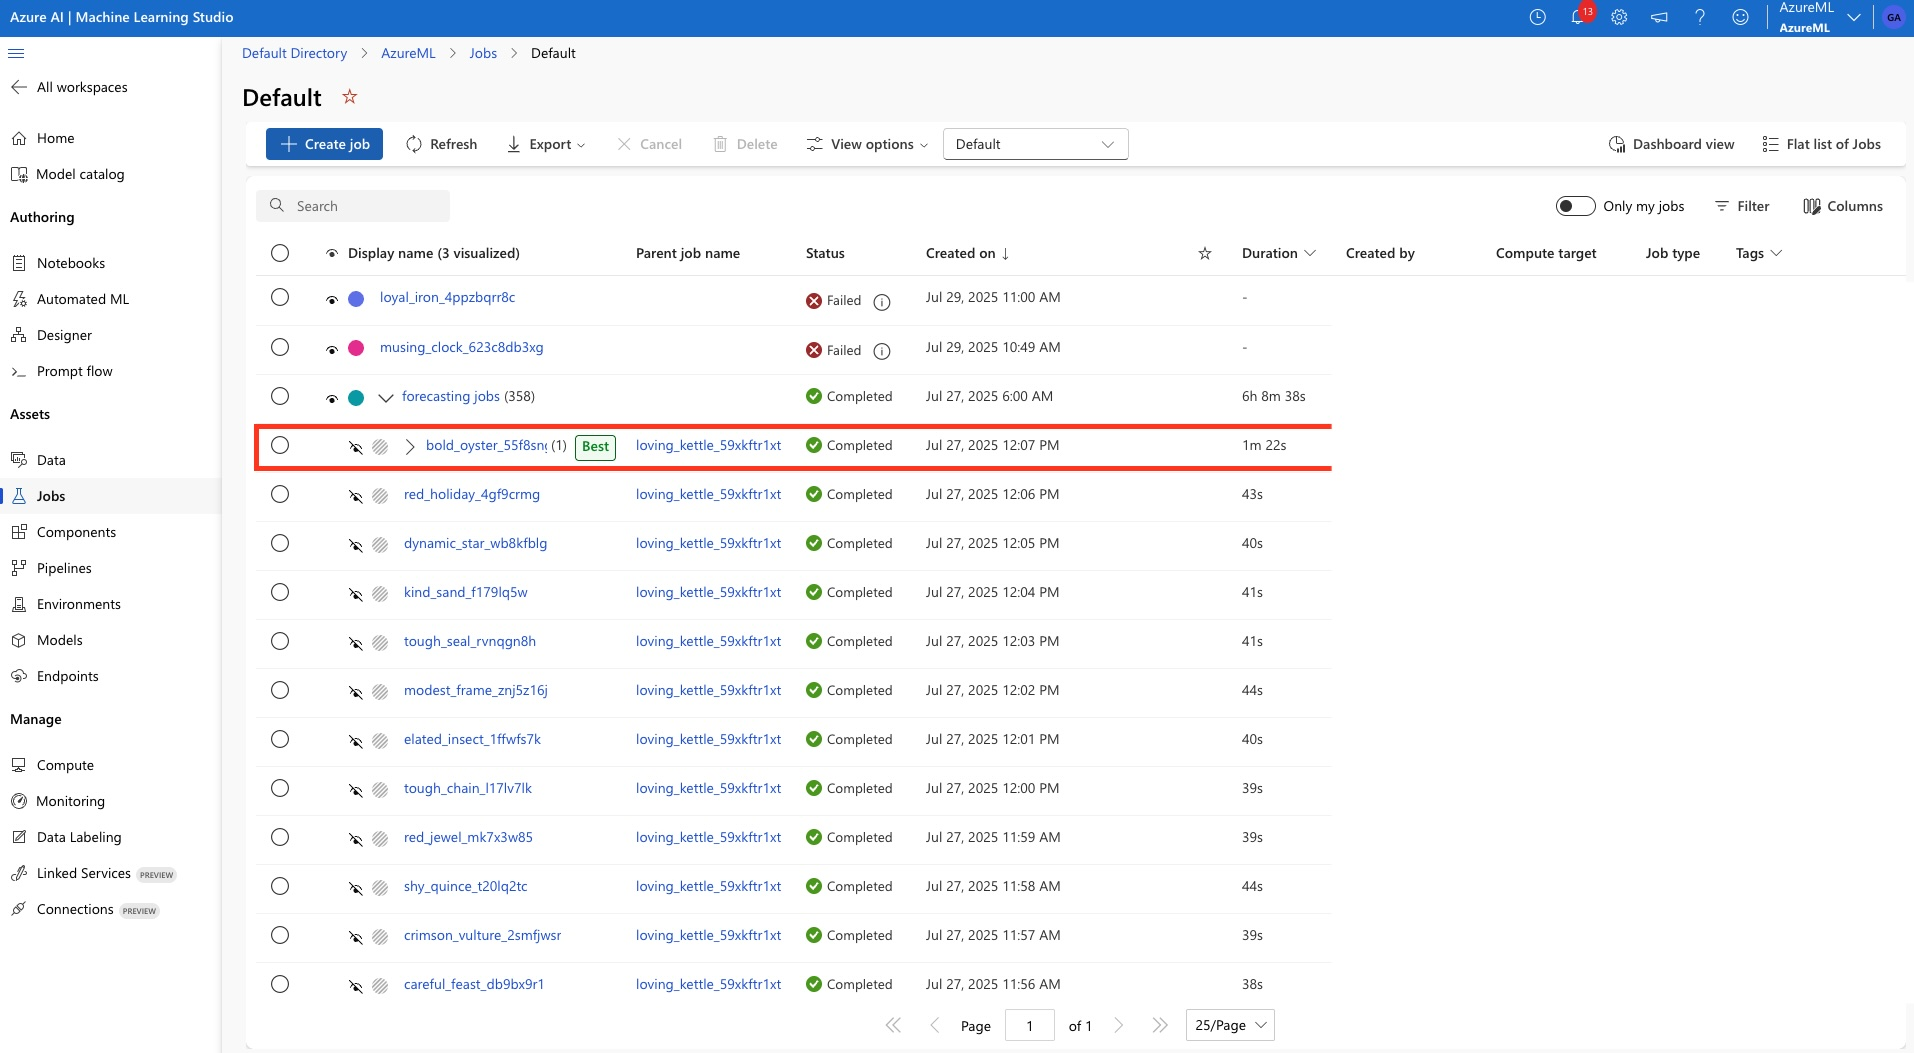

##### Get the Run ID
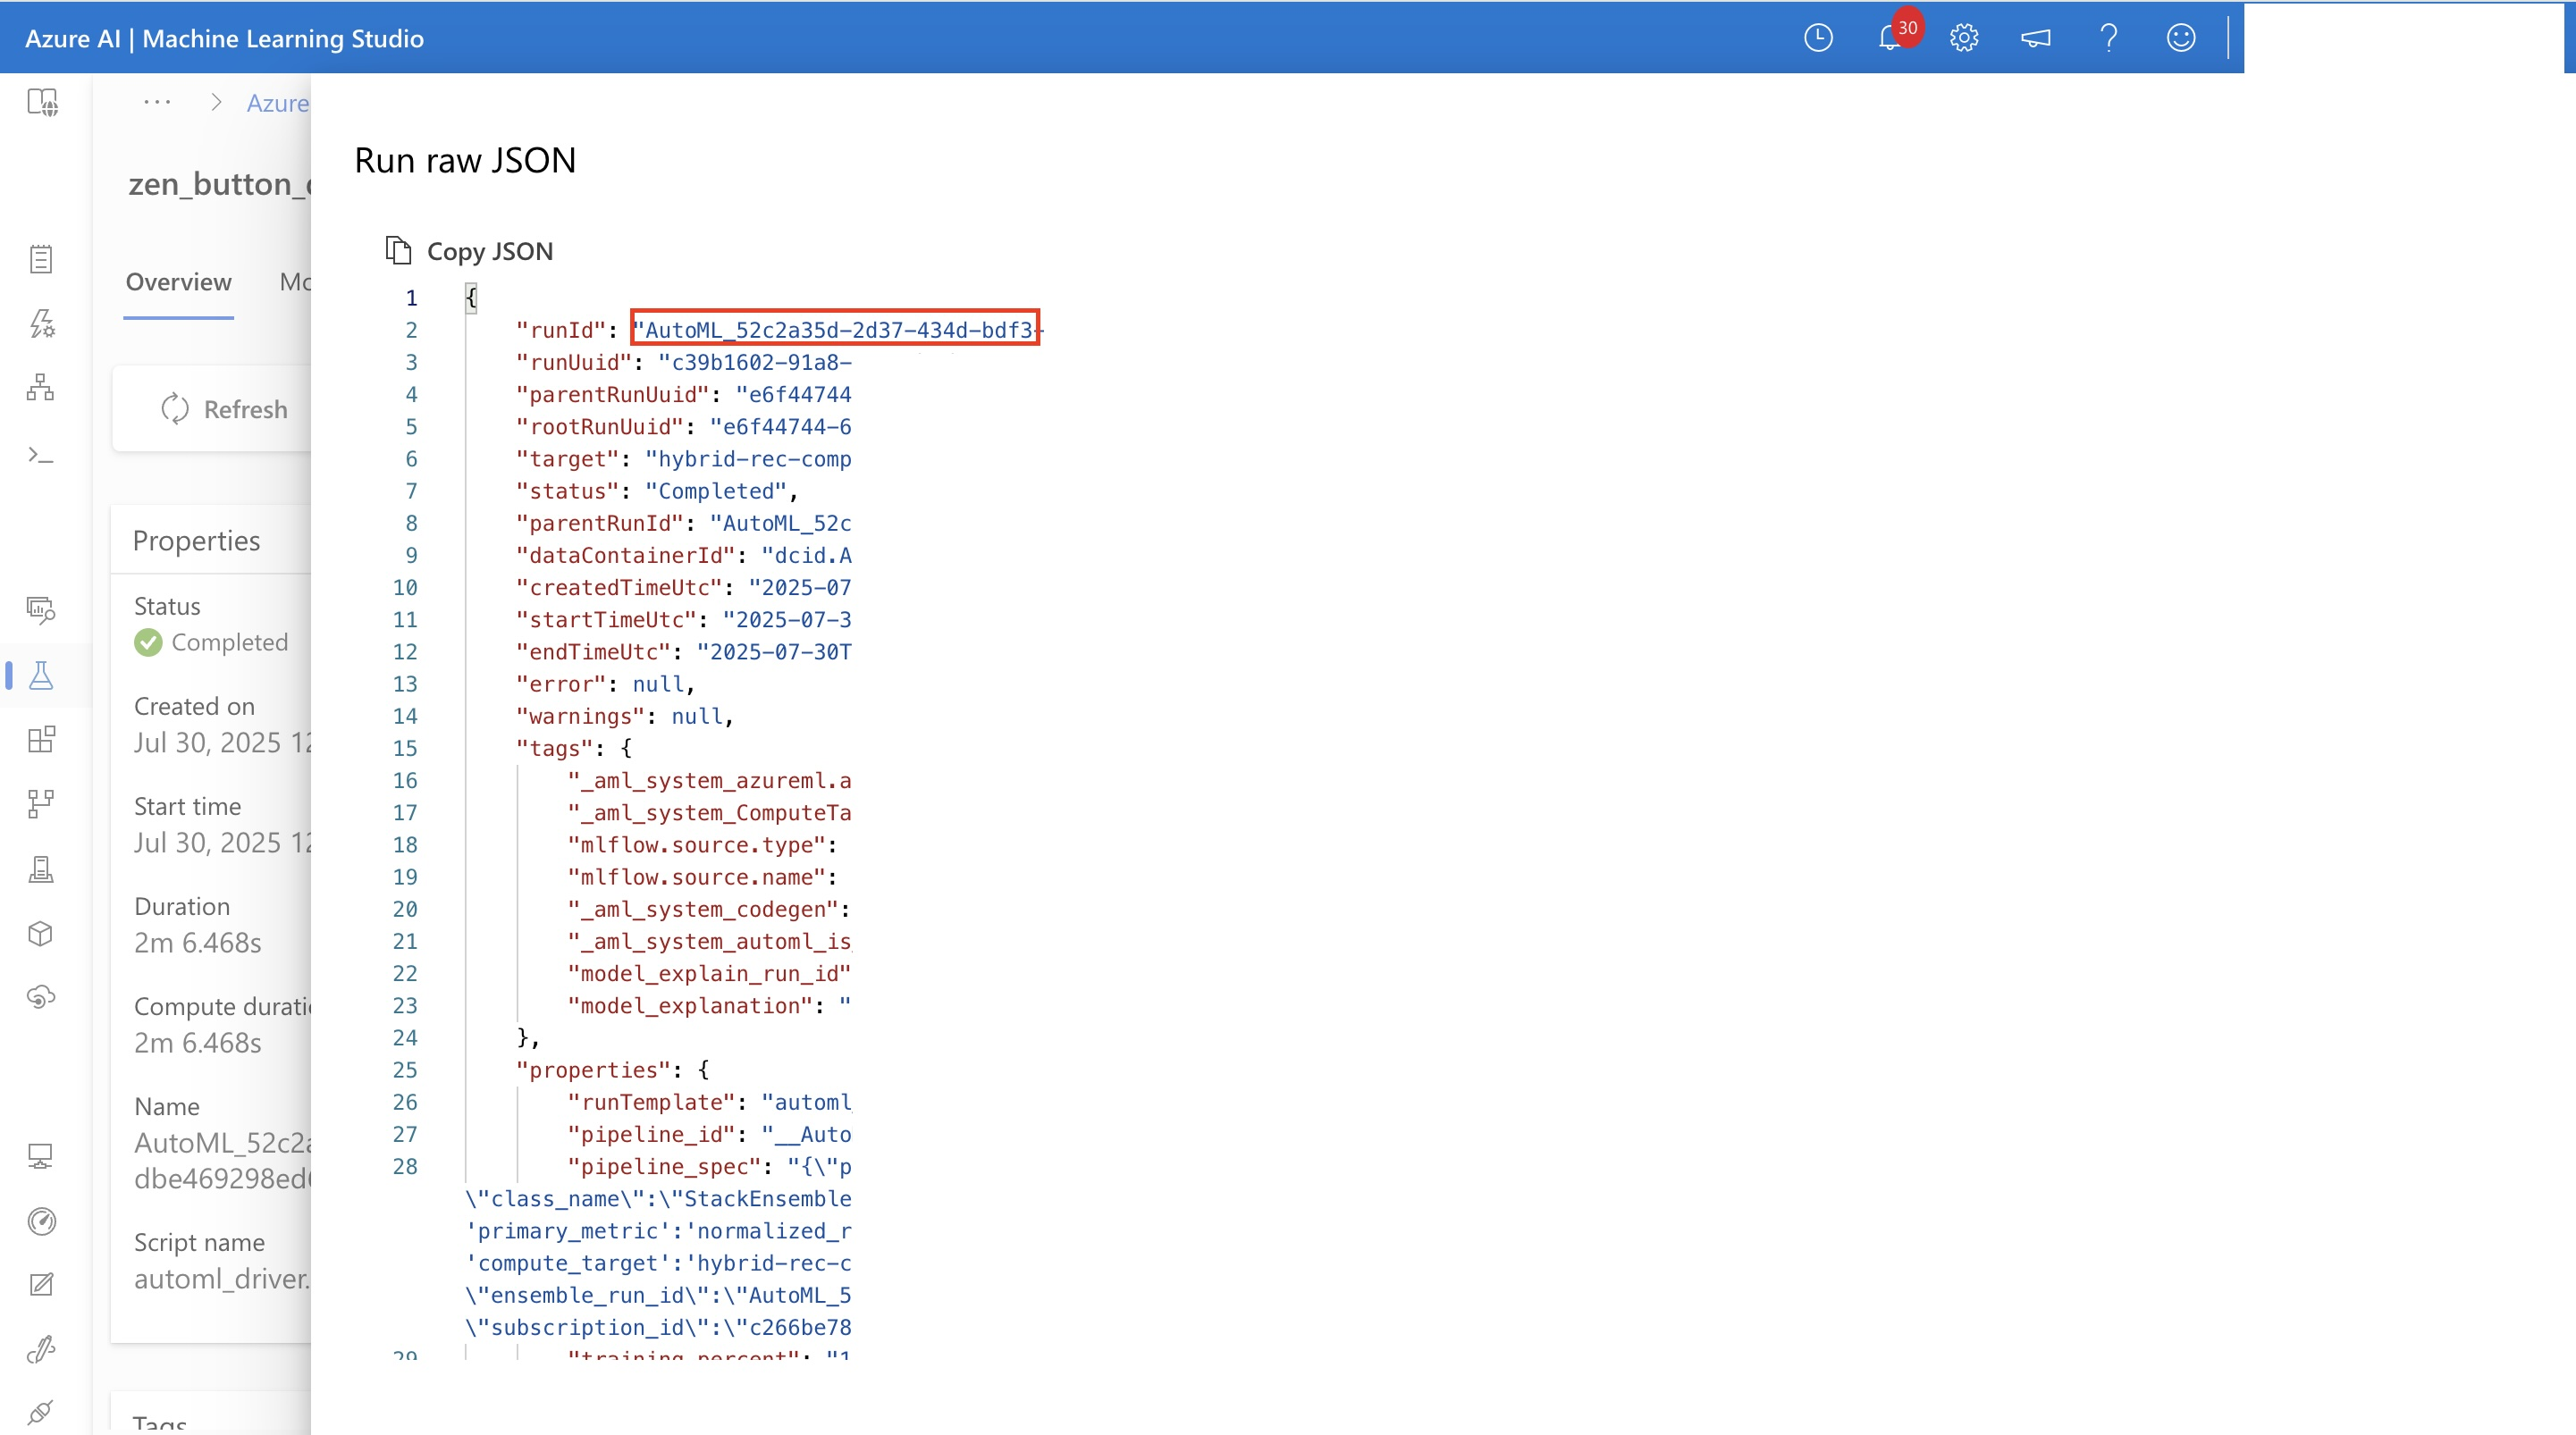

##### Register your model

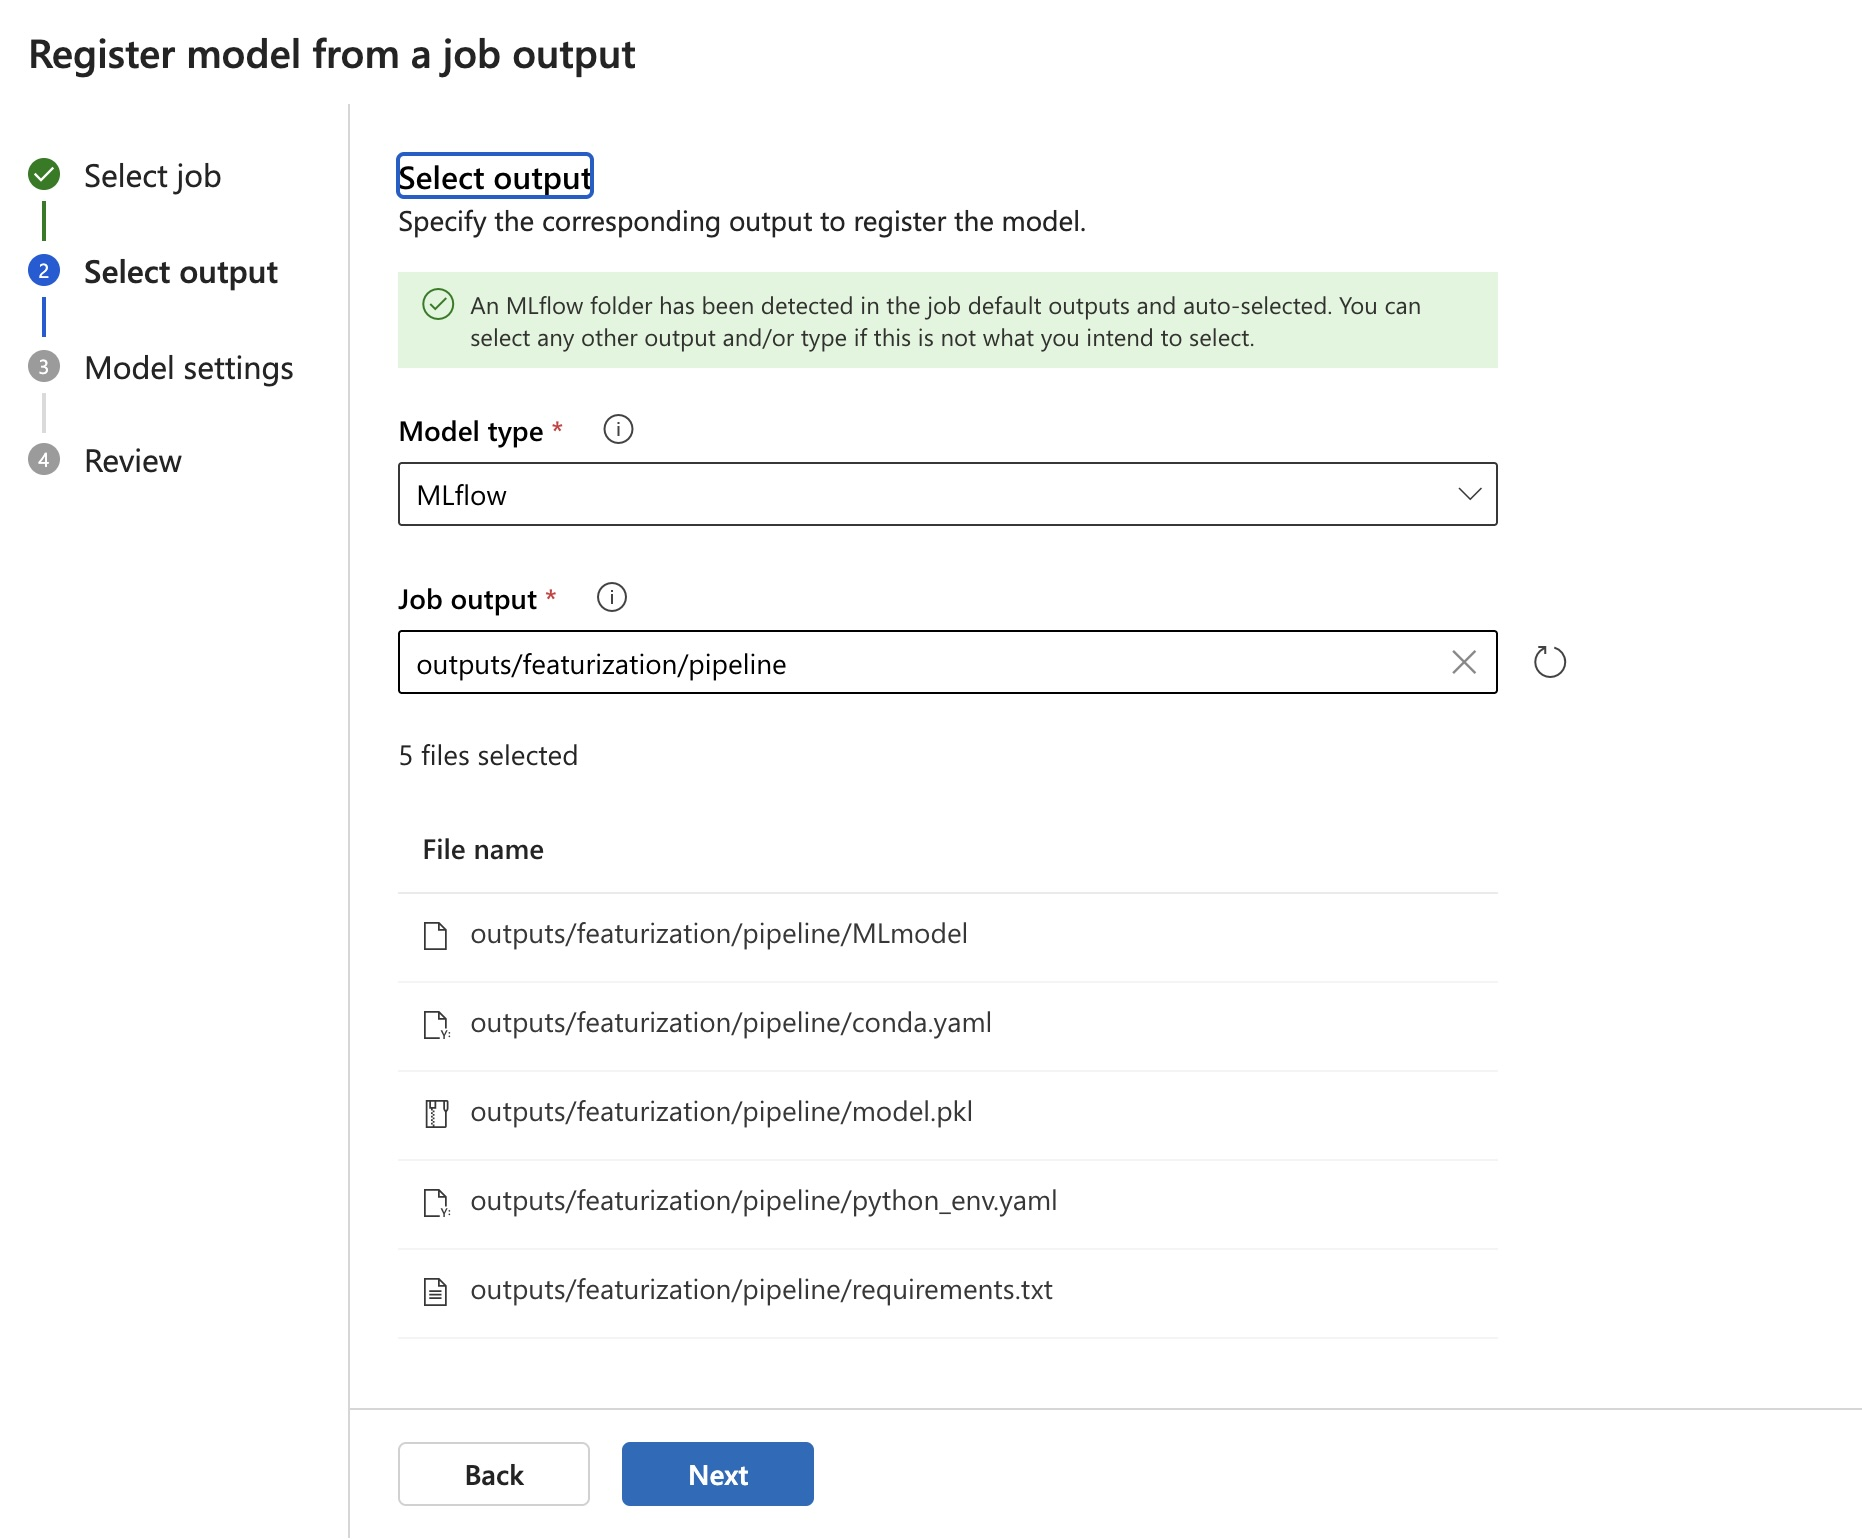

##### Deploy your model

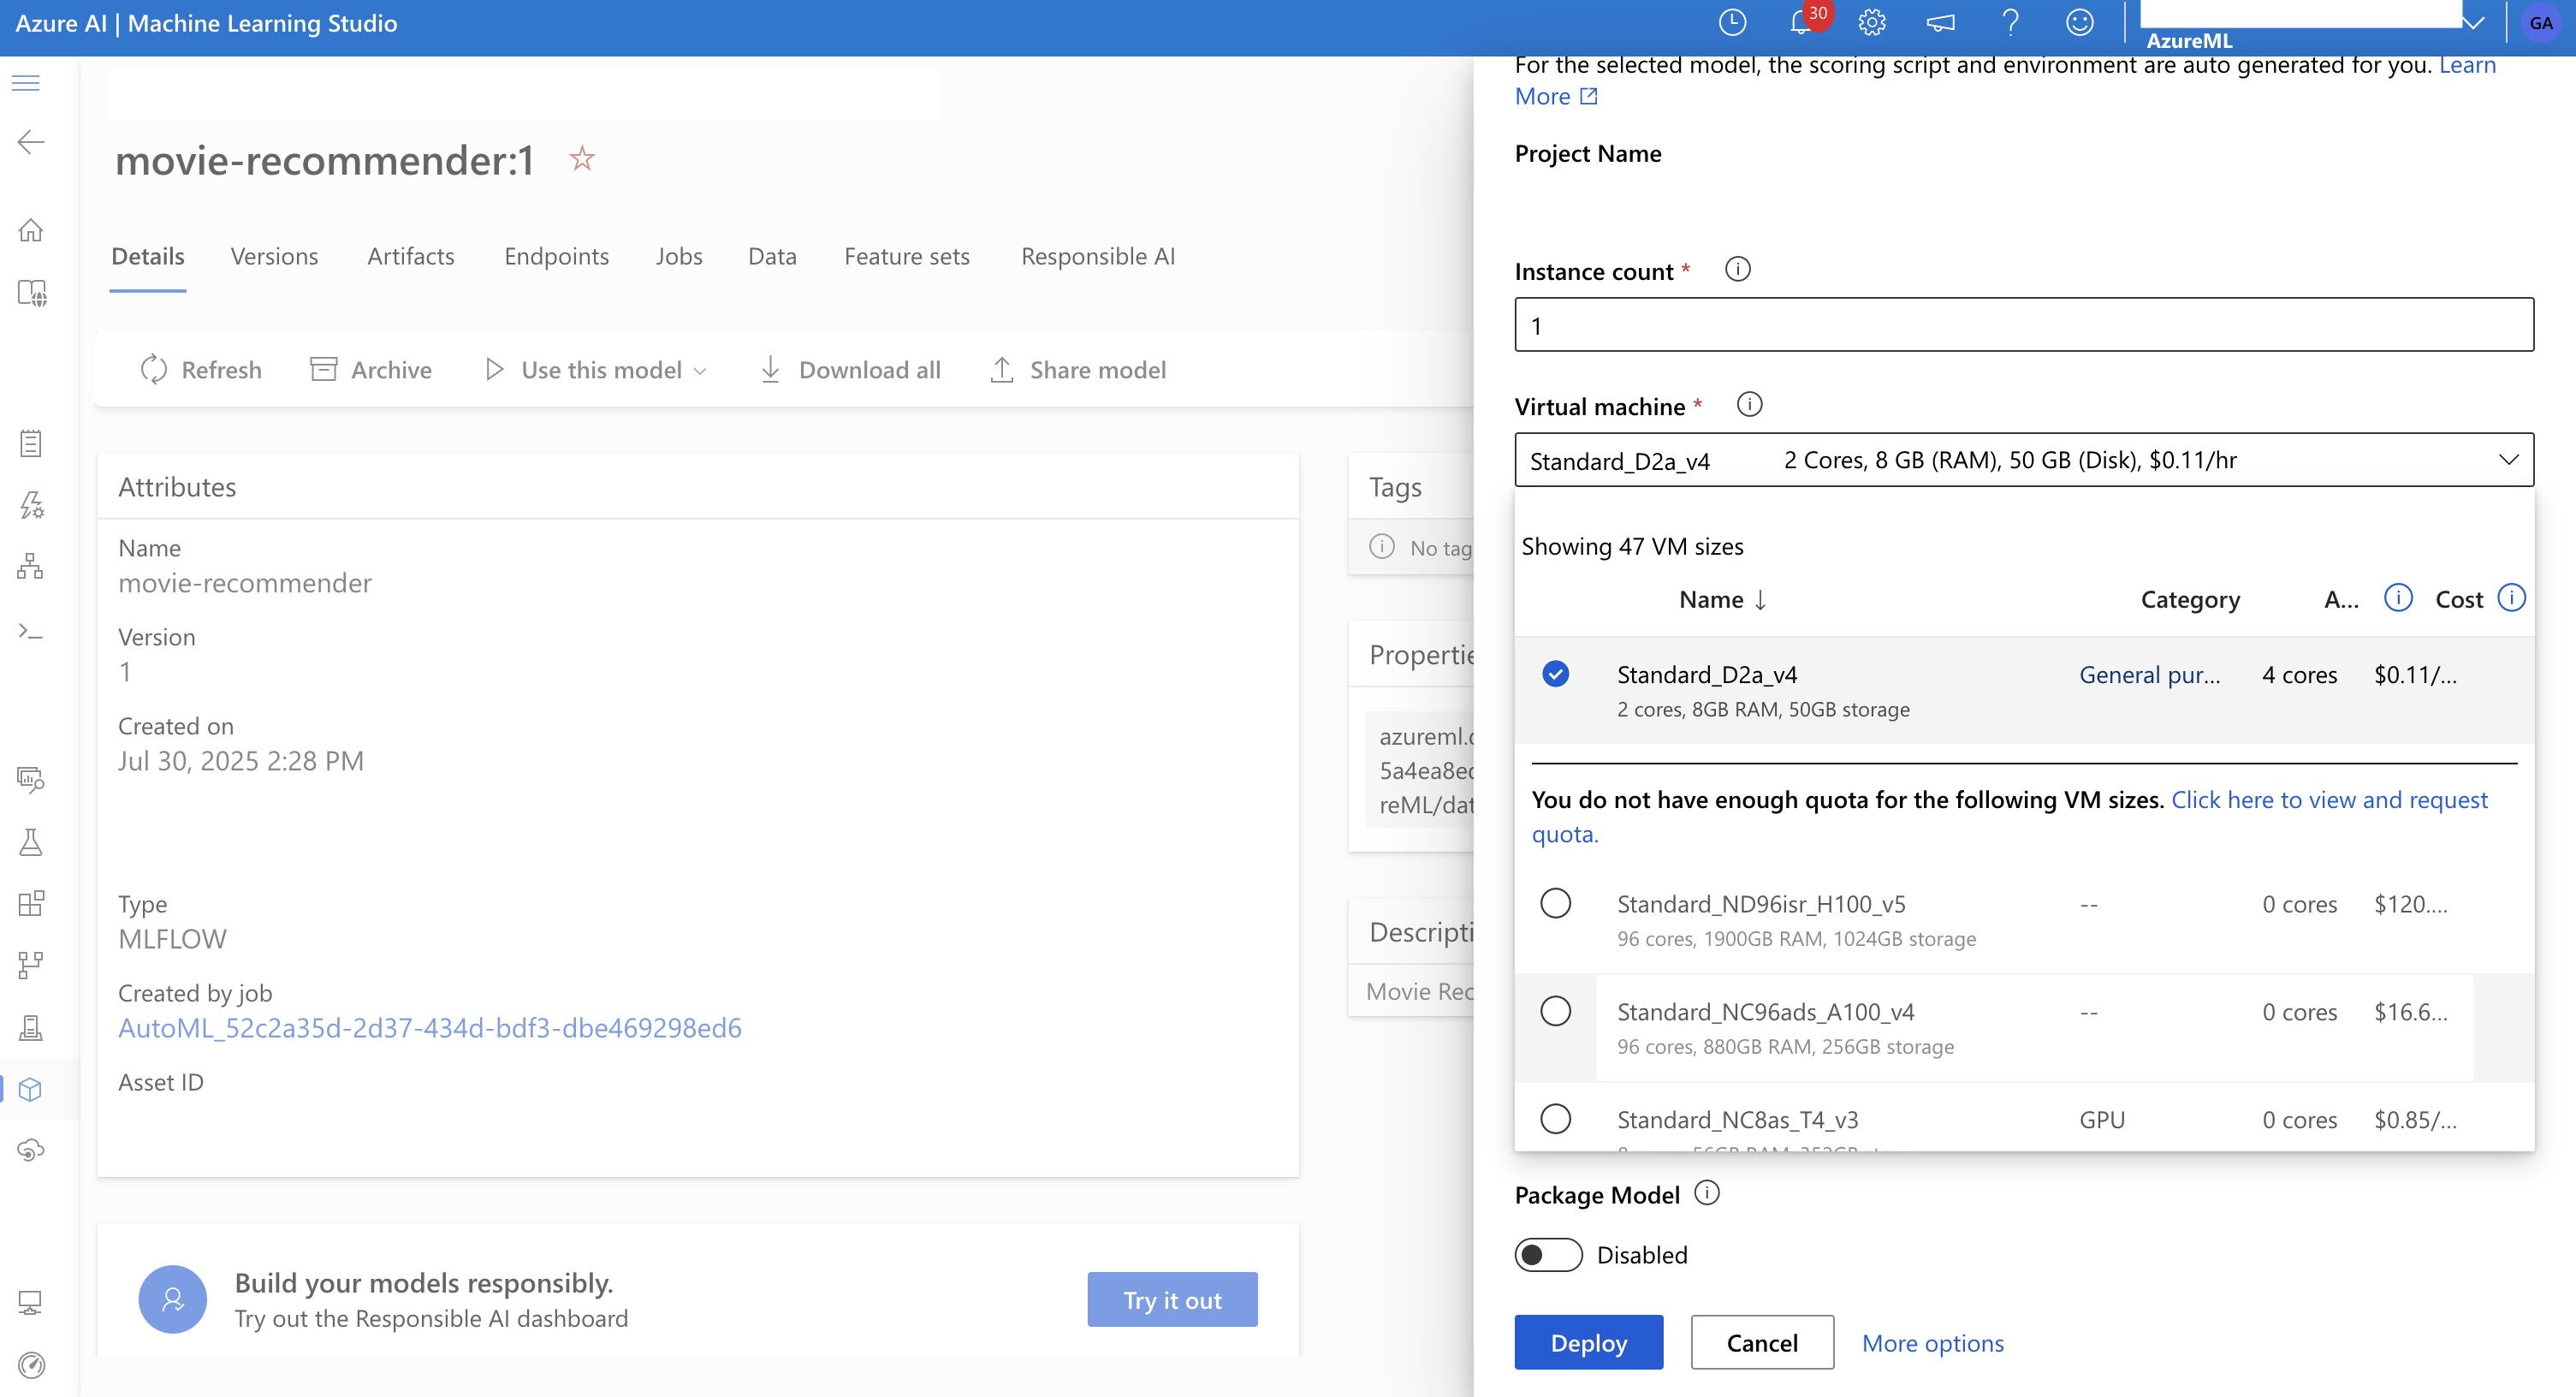

##### Congratulations - You've trained and deployed your first model on Microsoft Azure!

In [1]:
# Install Libraries
# !pip install --upgrade mlflow azureml-mlflow scikit-learn

In [2]:
# Fill this with your Workspace Information
subscription_id = "REPLACE THIS"  # You need to replace this
resource_group = "REPLACE THIS"  # You need to replace this
workspace_name = "REPLACE THIS"  # You need to replace this

"""
Learning objectives:
1. Extract user and product factors from a matrix factorization model using scikit-learn
2. Format inputs for Azure AutoML hybrid recommendation model
3. Train and deploy a hybrid recommendation system on Azure ML

## Introduction

This notebook demonstrates how to build a hybrid recommendation system that combines:
- Matrix factorization user/item embeddings 
- User metadata (synthetic loyalty, location data)
- Item metadata (movie genres, titles)

The approach uses Azure AutoML to automatically select and tune the best regression model
for predicting ratings based on these combined features.
"""

import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import joblib

# Azure ML imports
from azureml.core import Workspace, Dataset, Experiment, Environment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.train.automl import AutoMLConfig
from azureml.core.model import Model
from azureml.core.webservice import AciWebservice
import logging

# Set your Azure ML workspace details
SUBSCRIPTION_ID = subscription_id
RESOURCE_GROUP = resource_group
WORKSPACE_NAME = workspace_name
EXPERIMENT_NAME = "hybrid-recommendation-automl"

# Initialize workspace
ws = Workspace(subscription_id=SUBSCRIPTION_ID,
               resource_group=RESOURCE_GROUP,
               workspace_name=WORKSPACE_NAME)

print(f"Workspace: {ws.name}")
print(f"Region: {ws.location}")

Workspace: AzureML
Region: centralus


In [3]:
## Step 1: Load and Prepare MovieLens Data
def load_movielens_data():
    """
    Load MovieLens 20M dataset from CSV files
    Expected files: ratings.csv, movies.csv
    """
    # Load ratings data
    ratings_df = pd.read_csv('ratings.csv')
    print(f"Loaded {len(ratings_df)} ratings")
    
    # Load movies data  
    movies_df = pd.read_csv('movies.csv')
    print(f"Loaded {len(movies_df)} movies")
    
    # Parse genres into lists
    movies_df['genres_list'] = movies_df['genres'].str.split('|')
    
    return ratings_df, movies_df

def create_synthetic_user_features(ratings_df):
    """
    Create synthetic user features since MovieLens doesn't include user demographics
    """
    user_stats = ratings_df.groupby('userId').agg({
        'rating': ['count', 'mean', 'std']
    }).reset_index()
    
    user_stats.columns = ['userId', 'num_ratings', 'avg_rating', 'rating_std']
    user_stats['rating_std'] = user_stats['rating_std'].fillna(0)
    
    # Create synthetic features
    np.random.seed(42)
    user_stats['loyalty'] = np.random.rand(len(user_stats)) * user_stats['num_ratings']
    user_stats['postcode'] = (user_stats['userId'] % 100).astype(str).str.zfill(2)
    user_stats['age_group'] = np.random.choice(['18-25', '26-35', '36-45', '46-55', '55+'], 
                                               len(user_stats))
    
    return user_stats

In [4]:
## Step 2: Train Matrix Factorization Model
def train_matrix_factorization(ratings_df, n_factors=16, sample_size=50000):
    """
    Train matrix factorization model using sparse matrices and sampling for memory efficiency
    """
    print("Training matrix factorization model...")
    
    # Sample data if dataset is too large
    # if len(ratings_df) > sample_size:
    #     print(f"Sampling {sample_size} ratings from {len(ratings_df)} total ratings")
    #     ratings_sample = ratings_df.sample(n=sample_size, random_state=42)
    # else:
    #     ratings_sample = ratings_df.copy()
    ratings_sample = ratings_df.copy()
    # Use only active users and movies to reduce matrix size
    user_counts = ratings_sample['userId'].value_counts()
    movie_counts = ratings_sample['movieId'].value_counts()
    
    # Keep users with at least 10 ratings and movies with at least 5 ratings
    active_users = user_counts[user_counts >= 10].index
    active_movies = movie_counts[movie_counts >= 5].index
    
    # Filter to active users and movies
    filtered_ratings = ratings_sample[
        (ratings_sample['userId'].isin(active_users)) & 
        (ratings_sample['movieId'].isin(active_movies))
    ]
    
    print(f"Filtered to {len(active_users)} users and {len(active_movies)} movies")
    print(f"Matrix size: {len(active_users)} x {len(active_movies)} = {len(active_users) * len(active_movies):,} cells")
    
    # Create sparse user-item matrix using scipy
    from scipy.sparse import csr_matrix
    from sklearn.preprocessing import LabelEncoder
    
    # Encode users and movies to continuous indices
    user_encoder = LabelEncoder()
    movie_encoder = LabelEncoder()
    
    filtered_ratings['user_idx'] = user_encoder.fit_transform(filtered_ratings['userId'])
    filtered_ratings['movie_idx'] = movie_encoder.fit_transform(filtered_ratings['movieId'])
    
    # Create sparse matrix
    n_users = len(active_users)
    n_movies = len(active_movies)
    
    user_item_sparse = csr_matrix(
        (filtered_ratings['rating'].values, 
         (filtered_ratings['user_idx'].values, filtered_ratings['movie_idx'].values)),
        shape=(n_users, n_movies)
    )
    
    print(f"Sparse matrix created with {user_item_sparse.nnz:,} non-zero entries")
    print(f"Sparsity: {(1 - user_item_sparse.nnz / (n_users * n_movies)) * 100:.2f}%")
    
    # --- FIX: Removed alpha and l1_ratio to match scikit-learn v0.16 ---
    # Train NMF model on sparse matrix
    nmf_model = NMF(n_components=n_factors, 
                    init='random', 
                    random_state=42,
                    max_iter=100)  # Reduced iterations for speed
    
    # Fit and transform to get user factors
    print("Fitting NMF model...")
    user_factors = nmf_model.fit_transform(user_item_sparse)
    
    # Get item factors
    item_factors = nmf_model.components_.T
    
    # Create DataFrames for factors with original IDs
    user_factors_df = pd.DataFrame(user_factors, 
                                  columns=[f'user_factor_{i+1}' for i in range(n_factors)])
    user_factors_df['userId'] = user_encoder.inverse_transform(range(n_users))
    
    item_factors_df = pd.DataFrame(item_factors,
                                  columns=[f'item_factor_{i+1}' for i in range(n_factors)])
    item_factors_df['movieId'] = movie_encoder.inverse_transform(range(n_movies))
    
    print(f"User factors shape: {user_factors_df.shape}")
    print(f"Item factors shape: {item_factors_df.shape}")
    
    return user_factors_df, item_factors_df, nmf_model

In [5]:
## Step 3: Create Hybrid Dataset

def create_hybrid_dataset(ratings_df, movies_df, user_features_df, 
                         user_factors_df, item_factors_df, max_samples=100000):
    """
    Combine ratings with user factors, item factors, and metadata
    Memory-efficient version with sampling
    """
    print("Creating hybrid dataset...")
    
    # Sample ratings if too large
    if len(ratings_df) > max_samples:
        print(f"Sampling {max_samples} ratings from {len(ratings_df)} total")
        ratings_sample = ratings_df.sample(n=max_samples, random_state=42)
    else:
        ratings_sample = ratings_df.copy()
    
    # Start with sampled ratings
    hybrid_df = ratings_sample.copy()
    
    # Add user factors (only for users that exist in factors)
    hybrid_df = hybrid_df.merge(user_factors_df, on='userId', how='inner')
    print(f"After user factors merge: {len(hybrid_df)} rows")
    
    # Add user features
    hybrid_df = hybrid_df.merge(user_features_df, on='userId', how='left')
    print(f"After user features merge: {len(hybrid_df)} rows")
    
    # Add item factors (only for items that exist in factors)
    hybrid_df = hybrid_df.merge(item_factors_df, on='movieId', how='inner')
    print(f"After item factors merge: {len(hybrid_df)} rows")
    
    # Add movie metadata
    hybrid_df = hybrid_df.merge(movies_df[['movieId', 'title', 'genres']], 
                               on='movieId', how='left')
    print(f"After movie metadata merge: {len(hybrid_df)} rows")
    
    # Simplified genre handling - just use first genre
    hybrid_df['primary_genre'] = hybrid_df['genres'].str.split('|').str[0]
    hybrid_df['primary_genre'] = hybrid_df['primary_genre'].fillna('Unknown')
    
    # Encode categorical variables
    from sklearn.preprocessing import LabelEncoder
    
    le_genre = LabelEncoder()
    hybrid_df['genre_encoded'] = le_genre.fit_transform(hybrid_df['primary_genre'])
    
    le_postcode = LabelEncoder()
    hybrid_df['postcode_encoded'] = le_postcode.fit_transform(hybrid_df['postcode'])
    
    le_age = LabelEncoder()
    hybrid_df['age_group_encoded'] = le_age.fit_transform(hybrid_df['age_group'])
    
    # Select features for training
    feature_columns = (['userId', 'movieId'] + 
                      [f'user_factor_{i+1}' for i in range(16)] +
                      [f'item_factor_{i+1}' for i in range(16)] +
                      ['loyalty', 'num_ratings', 'avg_rating', 'rating_std',
                       'genre_encoded', 'postcode_encoded', 'age_group_encoded'])
    
    final_df = hybrid_df[feature_columns + ['rating']].copy()
    
    # Remove any rows with missing values
    final_df = final_df.dropna()
    
    print(f"Final hybrid dataset shape: {final_df.shape}")
    print(f"Memory usage: {final_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    return final_df, le_genre, le_postcode, le_age

In [6]:
## Step 4: Prepare Data for Azure AutoML

def prepare_automl_data(hybrid_df, ws):
    """
    Prepare and register dataset for Azure AutoML
    """
    print("Preparing data for Azure AutoML...")
    
    # Split data
    train_df, test_df = train_test_split(hybrid_df, test_size=0.2, random_state=42)
    
    # Save to CSV
    train_df.to_csv('train_data.csv', index=False)
    test_df.to_csv('test_data.csv', index=False)
    
    # Register datasets in Azure ML
    datastore = ws.get_default_datastore()
    
    # Upload and register training dataset
    train_dataset = Dataset.Tabular.from_delimited_files(
        path=datastore.upload_files(['train_data.csv'], 
                                   target_path='hybrid-recommendation/'),
        validate=True,
        include_path=False,
        infer_column_types=True,
        set_column_types=None,
        separator=',',
        header=True
    )
    
    train_dataset = train_dataset.register(
        workspace=ws,
        name='hybrid-recommendation-train',
        description='Training data for hybrid recommendation model',
        create_new_version=True
    )
    
    # Upload and register test dataset
    test_dataset = Dataset.Tabular.from_delimited_files(
        path=datastore.upload_files(['test_data.csv'], 
                                   target_path='hybrid-recommendation/'),
        validate=True,
        include_path=False,
        infer_column_types=True,
        separator=',',
        header=True
    )
    
    test_dataset = test_dataset.register(
        workspace=ws,
        name='hybrid-recommendation-test',
        description='Test data for hybrid recommendation model',
        create_new_version=True
    )
    
    return train_dataset, test_dataset, train_df, test_df

In [7]:
## Step 5: Configure and Run AutoML

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException # Good practice to catch a specific exception

def setup_compute_target(ws, compute_name="hybrid-rec-compute"):
    """
    Create or retrieve compute target for AutoML and wait for it to be ready.
    """
    # try:
    #     compute_target = ComputeTarget(workspace=ws, name=compute_name)
    #     print(f"Found existing compute target: {compute_name}")
        
    #     # --- FIX: Wait for the existing compute to be ready ---
    #     # This is crucial for clusters with min_nodes=0, as it waits for scaling up.
    #     print("Waiting for the compute target to be ready...")
    #     compute_target.wait_for_completion(show_output=True)
    #     print("Compute target is ready.")

    # except ComputeTargetException:
    print(f"Creating new compute target: {compute_name}")
    compute_config = AmlCompute.provisioning_configuration(
            vm_size="STANDARD_A4M_V2",
            min_nodes=0,
            max_nodes=1,
            idle_seconds_before_scaledown=300
        )
    compute_target = ComputeTarget.create(ws, compute_name, compute_config)
        
    # This wait is for the initial creation of the cluster
    compute_target.wait_for_completion(show_output=True)
    
    return compute_target

In [18]:

def configure_automl(train_dataset, compute_target):
    """
    Configure AutoML for regression task
    """
    automl_config = AutoMLConfig(
        task='regression',
        primary_metric='normalized_root_mean_squared_error',
        training_data=train_dataset,
        label_column_name='rating',
        compute_target=compute_target,
        experiment_timeout_minutes=60,
        max_concurrent_iterations=4,
        max_cores_per_iteration=-1,
        enable_early_stopping=True,
        n_cross_validations=5,
        verbosity=logging.INFO,
        enable_voting_ensemble=True,
        enable_stack_ensemble=True,
        # Feature engineering
        enable_feature_sweeping=True,
        featurization='auto',
        # Model selection
        blocked_models=['XGBoostRegressor'],  # This name is correct
        allowed_models=['RandomForest', 'LightGBM', 
                        'ExtremeRandomTrees', 'GradientBoosting',
                        'ElasticNet']
    )
    
    return automl_config

In [9]:
def run_automl_experiment(ws, automl_config):
    """
    Run AutoML experiment
    """
    experiment = Experiment(ws, EXPERIMENT_NAME)
    
    print("Starting AutoML run...")
    automl_run = experiment.submit(automl_config, show_output=True, wait_post_processing=True)
    
    # Get best model
    best_run, fitted_model = automl_run.get_output()
    
    print(f"Best model: {fitted_model}")
    print(f"Best run metrics:")
    print(best_run.get_metrics())
    
    return automl_run, best_run, fitted_model

In [10]:
## Step 6: Evaluate and Deploy Model
def evaluate_model(best_run, test_df):
    """
    Evaluate the best model on test data
    """
    print("Evaluating model on test data...")
    
    # Download the model
    model_path = best_run.download_file('outputs/model.pkl')
    model = joblib.load(model_path)
    
    # Prepare test features
    feature_columns = [col for col in test_df.columns if col != 'rating']
    X_test = test_df[feature_columns]
    y_test = test_df['rating']
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")
    
    return model, y_pred

In [11]:
def register_and_deploy_model(ws, best_run, model_name="hybrid-recommendation-model"):
    """
    Register and deploy the best model
    """
    print("Registering model...")
    
    # Register model
    model = best_run.register_model(
        model_name=model_name,
        description="Hybrid recommendation model trained with AutoML",
        tags={"type": "recommendation", "algorithm": "hybrid"}
    )
    
    print(f"Model registered: {model.name} version {model.version}")
    
    # Deploy as web service
    print("Deploying model...")
    
    # Create inference configuration
    inference_config = best_run.get_inference_config()
    
    # Create deployment configuration
    deployment_config = AciWebservice.deploy_configuration(
        cpu_cores=1,
        memory_gb=2,
        description="Hybrid recommendation model endpoint"
    )
    
    # Deploy
    service = Model.deploy(
        workspace=ws,
        name=f"{model_name}-service",
        models=[model],
        inference_config=inference_config,
        deployment_config=deployment_config,
        overwrite=True
    )
    
    service.wait_for_deployment(show_output=True)
    
    print(f"Service deployed at: {service.scoring_uri}")
    
    return model, service

In [12]:
## Step 7: Make Predictions
def make_recommendations(service, user_id, user_factors_df, item_factors_df, 
                        user_features_df, movies_df, top_k=10):
    """
    Make movie recommendations for a specific user
    """
    # Get user features
    user_data = user_features_df[user_features_df['userId'] == user_id].iloc[0]
    user_factors = user_factors_df[user_factors_df['userId'] == user_id].iloc[0]
    
    # Get all movies the user hasn't rated
    # (In practice, you'd filter out movies the user has already rated)
    
    recommendations = []
    
    # Sample some movies for demonstration
    sample_movies = movies_df.sample(100)
    
    for _, movie in sample_movies.iterrows():
        # Get movie factors
        movie_factors = item_factors_df[item_factors_df['movieId'] == movie['movieId']]
        
        if len(movie_factors) > 0:
            movie_factors = movie_factors.iloc[0]
            
            # Create input features
            features = {
                'userId': user_id,
                'movieId': movie['movieId'],
                'loyalty': user_data['loyalty'],
                'num_ratings': user_data['num_ratings'],
                'avg_rating': user_data['avg_rating'],
                'rating_std': user_data['rating_std'],
                # Add user factors
                **{f'user_factor_{i+1}': user_factors[f'user_factor_{i+1}'] 
                   for i in range(16)},
                # Add item factors  
                **{f'item_factor_{i+1}': movie_factors[f'item_factor_{i+1}'] 
                   for i in range(16)},
                # Add encoded features (simplified for demo)
                'genre_encoded': 0,  # Would need proper encoding
                'postcode_encoded': user_data.get('postcode_encoded', 0),
                'age_group_encoded': user_data.get('age_group_encoded', 0)
            }
            
            # Make prediction via web service
            import json
            input_data = json.dumps({'data': [list(features.values())]})
            
            try:
                prediction = service.run(input_data)
                predicted_rating = float(prediction[0])
                
                recommendations.append({
                    'movieId': movie['movieId'],
                    'title': movie['title'],
                    'predicted_rating': predicted_rating
                })
            except Exception as e:
                print(f"Error predicting for movie {movie['movieId']}: {e}")
    
    # Sort by predicted rating
    recommendations.sort(key=lambda x: x['predicted_rating'], reverse=True)
    
    return recommendations[:top_k]

In [13]:
# Step 1: Load data
print("=== Step 1: Loading Data ===")
ratings_df, movies_df = load_movielens_data()
user_features_df = create_synthetic_user_features(ratings_df)

=== Step 1: Loading Data ===
Loaded 20000263 ratings
Loaded 27278 movies


In [14]:
# Step 2: Train matrix factorization
print("\n=== Step 2: Training Matrix Factorization ===")
user_factors_df, item_factors_df, nmf_model = train_matrix_factorization(ratings_df)


=== Step 2: Training Matrix Factorization ===
Training matrix factorization model...
Filtered to 138493 users and 18345 movies
Matrix size: 138493 x 18345 = 2,540,654,085 cells
Sparse matrix created with 19,984,024 non-zero entries
Sparsity: 99.21%
Fitting NMF model...
User factors shape: (138493, 17)
Item factors shape: (18345, 17)


/tmp/ipykernel_15076/2589040002.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ratings['user_idx'] = user_encoder.fit_transform(filtered_ratings['userId'])
/tmp/ipykernel_15076/2589040002.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ratings['movie_idx'] = movie_encoder.fit_transform(filtered_ratings['movieId'])


In [15]:
# Step 3: Create hybrid dataset
print("\n=== Step 3: Creating Hybrid Dataset ===")
hybrid_df, le_genre, le_postcode, le_age = create_hybrid_dataset(
            ratings_df, movies_df, user_features_df, user_factors_df, item_factors_df
        )


=== Step 3: Creating Hybrid Dataset ===
Creating hybrid dataset...
Sampling 100000 ratings from 20000263 total
After user factors merge: 100000 rows
After user features merge: 100000 rows
After item factors merge: 99910 rows
After movie metadata merge: 99910 rows
Final hybrid dataset shape: (99910, 42)
Memory usage: 32.8 MB


In [16]:
# Step 4: Prepare for AutoML
print("\n=== Step 4: Preparing AutoML Data ===")
train_dataset, test_dataset, train_df, test_df = prepare_automl_data(hybrid_df, ws)


=== Step 4: Preparing AutoML Data ===
Preparing data for Azure AutoML...
Uploading an estimated of 1 files
Target already exists. Skipping upload for hybrid-recommendation/train_data.csv
Uploaded 0 files
Uploading an estimated of 1 files
Target already exists. Skipping upload for hybrid-recommendation/test_data.csv
Uploaded 0 files


In [ ]:
# Step 5: Setup and run AutoML
print("\n=== Step 5: Running AutoML ===")
compute_target = setup_compute_target(ws)
automl_config = configure_automl(train_dataset, compute_target)
automl_run, best_run, fitted_model = run_automl_experiment(ws, automl_config)

In [ ]:
# Step 6: Evaluate and deploy
# print("\n=== Step 6: Evaluating and Deploying Model ===")
# model, y_pred = evaluate_model(best_run, test_df)
# registered_model, service = register_and_deploy_model(ws, best_run)

In [43]:
# Step 6[MLFLOW]: Evaluate and deploy with ML Flow
from azure.ai.ml import MLClient, Input
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes
from azure.identity import DefaultAzureCredential

In [44]:
# Import the required libraries
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

credential = DefaultAzureCredential()
ml_client = MLClient(credential, subscription_id, resource_group, workspace_name)
workspace = ml_client.workspaces.get(name=ml_client.workspace_name)
print(ml_client.workspace_name, workspace.resource_group, workspace.location, ml_client.connections._subscription_id, sep = '\n')

ml_client = MLClient(DefaultAzureCredential(), subscription_id, resource_group, workspace)

In [ ]:
# First, let's verify the MLflow tracking URI and run
print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")
    
# Initialize the MLflow client
client = MlflowClient()
    
# Get the current active run or specify a run_id
run_id = "REPLACE THIS"  # You need to replace this
print(f"Using specified run ID: {run_id}")

In [ ]:
run_info = client.get_run(run_id)
print(f"Run status: {run_info.info.status}")
print(f"Run lifecycle_stage: {run_info.info.lifecycle_stage}")

In [ ]:
# MLflow Model Loading and Testing for Jupyter Notebook

# Set the path to your model in the artifact_downloads folder
model_path = "./artifact_downloads/model.pkl"  # Adjust path as needed
# Alternative if you have an MLflow model directory:
# model_path = "./artifact_downloads/"

print("Loading MLflow model...")

try:
    # Method 1: Load as MLflow PyFunc model (recommended)
    model = mlflow.pyfunc.load_model(model_path)
    print("✅ Model loaded successfully as MLflow PyFunc")
    
    # Display model info
    print(f"Model type: {type(model)}")
    
except Exception as e:
    print(f"❌ Error loading MLflow model: {e}")
    print("Trying alternative loading method...")
    
    try:
        # Method 2: Load using pickle (if it's a pickle file)
        import pickle
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        print("✅ Model loaded successfully using pickle")
    except Exception as e2:
        print(f"❌ Error loading with pickle: {e2}")
        model = None

# Test the model if loaded successfully
if model is not None:
    print("\n" + "="*50)
    print("TESTING THE MODEL")
    print("="*50)
    
    # Create sample test data based on the documentation format
    # This follows the diabetes dataset format (10 features)
    test_data = {
        "columns": [
            "age", "sex", "bmi", "bp", "s1", "s2", "s3", "s4", "s5", "s6"
        ],
        "data": [
            [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
            [10.0, 2.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0]
        ],
        "index": [0, 1]
    }
    
    # Convert to DataFrame (MLflow PyFunc expects DataFrame input)
    df = pd.DataFrame(test_data["data"], columns=test_data["columns"])
    print("Test input data:")
    print(df)
    
    try:
        # Make predictions
        predictions = model.predict(df)
        print(f"\n✅ Predictions: {predictions}")
        print(f"Prediction type: {type(predictions)}")
        print(f"Shape: {predictions.shape if hasattr(predictions, 'shape') else 'N/A'}")
        
    except Exception as e:
        print(f"❌ Error making predictions: {e}")
        
        # Try alternative prediction format if the first fails
        try:
            # Some models might expect different input format
            predictions = model.predict(test_data["data"])
            print(f"✅ Predictions (alternative format): {predictions}")
        except Exception as e2:
            print(f"❌ Error with alternative prediction format: {e2}")

# Additional model inspection
if model is not None:
    print("\n" + "="*50)
    print("MODEL INSPECTION")
    print("="*50)
    
    # Check if it's an MLflow model with metadata
    try:
        if hasattr(model, 'metadata'):
            print("Model metadata:")
            print(f"- Input schema: {model.metadata.get_input_schema()}")
            print(f"- Output schema: {model.metadata.get_output_schema()}")
    except:
        pass
    
    # Check available attributes
    print("\nModel attributes:")
    for attr in dir(model):
        if not attr.startswith('_'):
            print(f"- {attr}")

print("\n" + "="*50)
print("TESTING COMPLETE")
print("="*50)

# Instructions for next steps
print("\nNext Steps:")
print("1. If the model loaded successfully, you can use it for predictions")
print("2. To deploy to Azure ML, follow the Azure CLI steps in the documentation")
print("3. Modify the test_data to match your specific use case")
print("4. Check the conda_env_v_1_0_0.yml file for environment dependencies")